# import funcs and load hydrographics profiles ds

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate

import xarray as xr
import dask.array as da
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches # for creating legend
import matplotlib.dates as mdates # converts datetime64 to datetime

import cartopy
import cartopy.crs as ccrs # for plotting
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point # for wrapping map fully - avoiding white line on 0 deg
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.dates as mdates # converts datetime64 to datetime
import matplotlib.gridspec as gridspec # to create grid-shaped combos of axes
from mpl_toolkits import mplot3d # 3d plotting tool
import cmocean # for nice oceanography colour pallettes

#import argopy
#from argopy import DataFetcher as ArgoDataFetcher # to load Argo ds directly

import os # for finding files

import gsw # for conversion functions

from tqdm.notebook import tqdm_notebook as tqdm
import glob # for downloading data
import sys # for path to functions

import seaborn as sns

sns.set(#font='Franklin Gothic Book',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'w', 
                            # '#aeaeae',
         'axes.grid': False,
         'axes.labelcolor': 'k',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1)
mpl.rcParams["figure.titlesize"] = 40
mpl.rcParams["axes.titlesize"] = 40
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams["font.size"] = 20
mpl.rcParams["xtick.labelsize"] = 20
mpl.rcParams["ytick.labelsize"] = 20
mpl.rcParams["ytick.labelright"] = False

from warnings import filterwarnings as fw
fw('ignore')

# import my own funcs
import sys
sys.path.append('/home/theospira/notebooks/projects/WW_climatology/functions')
from plot_formatting import circular_boundary,plot_nice_box
from inspection_funcs import boxplot
from calculations import *

import importlib
#importlib.reload(sys.modules['inspection_plot'])

# run smoothing on temp and psal then calc asal, ct, mlp and n2

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [2]:
# QC'ed data with mixed layer
ds = xr.open_dataset('/home/theospira/notebooks/projects/WW_climatology/data/hydrographic_profiles/qc_profile_ds_2dbar.nc')

# take only profiles south of SAF, which is max at -40.5°S
idx = np.where(ds.lat < -40)[0]

ds = ds.sel(pres=slice(10,400)).isel(n_prof=idx)
ds['n_prof'] = np.arange(ds.n_prof.size)

In [5]:
ds = gauss_filter_z(ds)

In [13]:
ds_smth = ds.copy()

In [14]:
ds = ds_smth.isel(n_prof=slice(250000,251000)).copy()

In [15]:
import gsw

# introduce absolute solinity into ds using gsw package
ds["asal"]=gsw.SA_from_SP(ds["psal"],ds["pres"]/1000,ds["lon"],ds["lat"]).astype("float32")
ds["asal"].name = "Salinity"
ds["asal"].attrs["long_name"] = "Absolute Salinity"
ds["asal"].attrs["standard_name"] = "ASAL"
ds["asal"].attrs["units"] = "g/kg"

# introduce conservative temp into ds using gsw package
ds["ctemp"]=gsw.CT_from_t(ds["asal"],ds["temp"],ds["pres"]/1000).astype("float32")
ds["ctemp"].name = "CT"
ds["ctemp"].attrs["long_name"] = "Conservative Temperature"
ds["ctemp"].attrs["standard_name"] = "CTEMP"
ds["ctemp"].attrs["units"] = "degrees_Celcius"

## this NEEDS to be calcs using SA and CT!!!
ds["rho"]=gsw.density.rho(ds["asal"],ds["ctemp"],ds["pres"]/1000).astype("float32")
ds["rho"].name = "Density"
ds["rho"].attrs["long_name"] = "In-situ Density"
ds["rho"].attrs["standard_name"] = "rho"
ds["rho"].attrs["units"] = "kg/m^-3"

ds['sig'] = gsw.sigma0(ds.asal, ds.ctemp)
ds["sig"].name = "Density"
ds["sig"].attrs["long_name"] = "Potential Density"
ds["sig"].attrs["standard_name"] = "sigma"
ds["sig"].attrs["units"] = "kg/m^-3"

In [17]:
# import my own funcs
import sys
sys.path.append('/home/theospira/notebooks/projects/WW_climatology/functions')
from plot_formatting import circular_boundary,plot_nice_box
from inspection_funcs import boxplot

import importlib

from calculations import calc_mlp, calc_ww

ds = calc_mlp(ds)

# calculate n2 and add to ds
g = 9.8
rho0 = 1025
ds['n2'] = -g/rho0 * ds.rho.diff(dim='pres') / -ds.pres.diff('pres')

# WW defintion:

### $$
\text{Does WW contain a temperature inversion below ML?} \left\{
    \begin{array}\\
        \text{no}  & \Rightarrow \ \text{ML WW (type 1),} \\
        \text{yes} & \Rightarrow \ \text{Sub-ML WW (type 2).} \\
    \end{array}
\right.
$$

|                | WW Type 1  (ML)                             | WW Type 2 (subsurf)                        |
|----------------|---------------------------------------------|--------------------------------------------|
| upper boundary | 10dbar                                      | ML                                         |
| core           | mid-MLD and avg T in ML & $T_{core}$ < 2°C | $T_{min}$ s.t. up bd < core$_z$ < lw bd & $T_{min}$ < 2°C. check for temp difference from ML reference temp: $T < T_{ML}$. $\therefore \exists$ WW iff $T - T_{ML} < 0$|
| lower boundary | mld          |WW core < $\frac{dT}{dz}_{max}$ < 300dbar          |

In [19]:
ds = calc_ww(ds)

profile idx:   0%|          | 0/593011 [00:00<?, ?it/s]

In [20]:
# compute a vertical mask of WW
ww_msk = np.ndarray(ds.ctemp.shape)*np.nan
up_bd  = (ds.up_bd / 2).astype(int).data # divide by 2 to get as indeces
lw_bd  = (ds.lw_bd / 2).astype(int).data # divide by 2 to get as indeces
condn  = ds.ctemp.notnull().sum('pres').data # grid cell contains non-nan ct data

# assign
for i in tqdm(range(ww_msk.shape[0]),"calc ww_mask"):
    if condn[i] != 0:
        ww_msk[i,up_bd[i]:lw_bd[i]] = 1

ds['ww_msk'] = xr.DataArray(ww_msk,
                              dims   = {'n_prof':ds.n_prof.data,'pres':ds.pres.data,},
                              coords = {'n_prof':ds.n_prof.data,'pres':ds.pres.data,},
                            )

calc ww_mask:   0%|          | 0/593011 [00:00<?, ?it/s]

ds.attrs['description'] = "Interpolated dataset from 2004 to 2021. Contains MLD from pre-interpolated data. Contains good QC and Wilson et al (2019) QC. Smoothed temp and psal using Gauss smoothing with stand dev=2. Gsw funcs and WW subsequently calculated "
ds['dsource']=ds['dsource'].astype(str)
ds.to_netcdf('/home/theospira/notebooks/projects/WW_climatology/data/hydrographic_profiles/ww_gauss_smoothed_ds_v1.nc')
print('completed it m8')

# apply some further QC

In [21]:
# lower boundary no deeper than 300 dbar
ww_vars = ['up_bd','ww_cp','ww_ct','ww_sa','sig_c',
           'lw_bd','ww_type','thcc','ww_n2']

ds[ww_vars] = ds[ww_vars].where(ds.lw_bd < 300) 

# remove any profiles that have fewer than 10 datapoints in rho
ds = ds.where(ds.rho.notnull().sum('pres') > 10,drop=True)
ds.attrs['description'] = "Interpolated dataset from 2004 to 2021. Contains MLD from pre-interpolated data. Contains good QC and Wilson et al (2019) QC. Smoothed temp and psal using Gauss smoothing with stand dev=2. Gsw funcs and WW subsequently calculated. Further QC post calculation: NaN any WW vars profiles with a lower boundary deeper than 300dbar; drop any profiles with fewer than 10 datapoints."

ds['dsource']=ds['dsource'].astype(str)
ds.to_netcdf('/home/theospira/notebooks/projects/WW_climatology/data/hydrographic_profiles/ww_gauss_smoothed_ds.nc')

In [ ]:
ds

In [11]:
ds

<xarray.Dataset>
Dimensions:  (n_prof: 592946, pres: 196)
Coordinates:
  * n_prof   (n_prof) int64 0 1 2 3 4 5 ... 620288 620289 620290 620291 620292
  * pres     (pres) int64 10 12 14 16 18 20 22 ... 388 390 392 394 396 398 400
    lon      (n_prof) float64 -47.64 -3.374 19.1 -57.59 ... 61.33 -106.7 156.9
    lat      (n_prof) float64 -57.46 -69.32 -58.43 ... -41.05 -42.42 -65.83
    time     (n_prof) datetime64[ns] 2004-01-01T10:01:28.999999744 ... 2021-1...
Data variables: (12/20)
    temp     (n_prof, pres) float64 1.849 1.835 1.809 1.773 ... 1.119 1.12 1.121
    psal     (n_prof, pres) float64 33.78 33.78 33.78 ... 34.68 34.68 34.68
    dsource  (n_prof) <U7 'Argo' 'Argo' 'Argo' 'Argo' ... 'Argo' 'Argo' 'Argo'
    mld      (n_prof) float64 22.09 45.83 19.12 34.81 ... 41.89 71.35 39.7 12.87
    asal     (n_prof, pres) float32 33.94 33.94 33.94 ... 34.85 34.85 34.85
    ctemp    (n_prof, pres) float32 1.855 1.841 1.815 1.779 ... 1.12 1.121 1.121
    ...       ...
    sig_c    (n_prof) float64 27.22 27.68 27.4 nan 27.65 ... 27.29 nan nan 27.45
    lw_bd    (n_prof) float64 118.0 164.0 124.0 nan 150.0 ... 96.0 nan nan 134.0
    ww_type  (n_prof) float64 2.0 2.0 2.0 nan 2.0 2.0 ... nan 2.0 nan nan 2.0
    thcc     (n_prof) float64 106.0 130.0 114.0 nan 136.0 ... 68.0 nan nan 124.0
    ww_n2    (n_prof) float64 0.001498 0.001361 0.003633 ... nan nan 0.002991
    ww_msk   (n_prof, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:  Interpolated dataset from 2004 to 2021. Contains MLD from p...

# check WW inversion is at least a certain temp difference from surface layer

In [12]:
idx = np.where(ds.ww_type==2)[0]
tmp = ds.isel(n_prof=idx)

In [14]:
ds.isel(n_prof=np.where(~np.isnan(ds.ww_type))[0])

<xarray.Dataset>
Dimensions:  (n_prof: 266856, pres: 196)
Coordinates:
  * n_prof   (n_prof) int64 0 1 2 4 5 7 ... 620284 620286 620287 620289 620292
  * pres     (pres) int64 10 12 14 16 18 20 22 ... 388 390 392 394 396 398 400
    lon      (n_prof) float64 -47.64 -3.374 19.1 -11.68 ... 50.06 113.6 156.9
    lat      (n_prof) float64 -57.46 -69.32 -58.43 ... -55.64 -62.1 -65.83
    time     (n_prof) datetime64[ns] 2004-01-01T10:01:28.999999744 ... 2021-1...
Data variables: (12/20)
    temp     (n_prof, pres) float64 1.849 1.835 1.809 1.773 ... 1.119 1.12 1.121
    psal     (n_prof, pres) float64 33.78 33.78 33.78 ... 34.68 34.68 34.68
    dsource  (n_prof) <U7 'Argo' 'Argo' 'Argo' 'Argo' ... 'Argo' 'Argo' 'Argo'
    mld      (n_prof) float64 22.09 45.83 19.12 15.05 ... 110.2 41.89 12.87
    asal     (n_prof, pres) float32 33.94 33.94 33.94 ... 34.85 34.85 34.85
    ctemp    (n_prof, pres) float32 1.855 1.841 1.815 1.779 ... 1.12 1.121 1.121
    ...       ...
    sig_c    (n_prof) float64 27.22 27.68 27.4 27.65 ... 27.29 27.34 27.29 27.45
    lw_bd    (n_prof) float64 118.0 164.0 124.0 150.0 ... 256.0 234.0 96.0 134.0
    ww_type  (n_prof) float64 2.0 2.0 2.0 2.0 2.0 2.0 ... 2.0 2.0 2.0 2.0 2.0
    thcc     (n_prof) float64 106.0 130.0 114.0 136.0 ... 180.0 136.0 68.0 124.0
    ww_n2    (n_prof) float64 0.001498 0.001361 0.003633 ... 0.002236 0.002991
    ww_msk   (n_prof, pres) float64 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    description:  Interpolated dataset from 2004 to 2021. Contains MLD from p...

In [34]:
mlp_idx = tmp.mlp.data / 2
mlp = tmp.mlp.data

In [20]:
i = 0

In [35]:
mlp[0]

12.0

In [39]:
# check ML temperature
ml_t = np.ndarray(tmp.mlp.shape)*np.nan
mlp = tmp.mlp.data

for i in tqdm(range(len(mlp))):
    ml_t[i] = tmp.isel(n_prof=i).ctemp.sel(pres=slice(0,mlp[i])).mean()

  0%|          | 0/161268 [00:00<?, ?it/s]

In [45]:
tmp['ml_t'] = xr.DataArray(ml_t,dims = {'n_prof':tmp.n_prof.data},coords = {'n_prof':tmp.n_prof.data},)

In [138]:
(tmp.ml_t - tmp.ww_ct < 0).sum()

<xarray.DataArray ()>
array(7989)

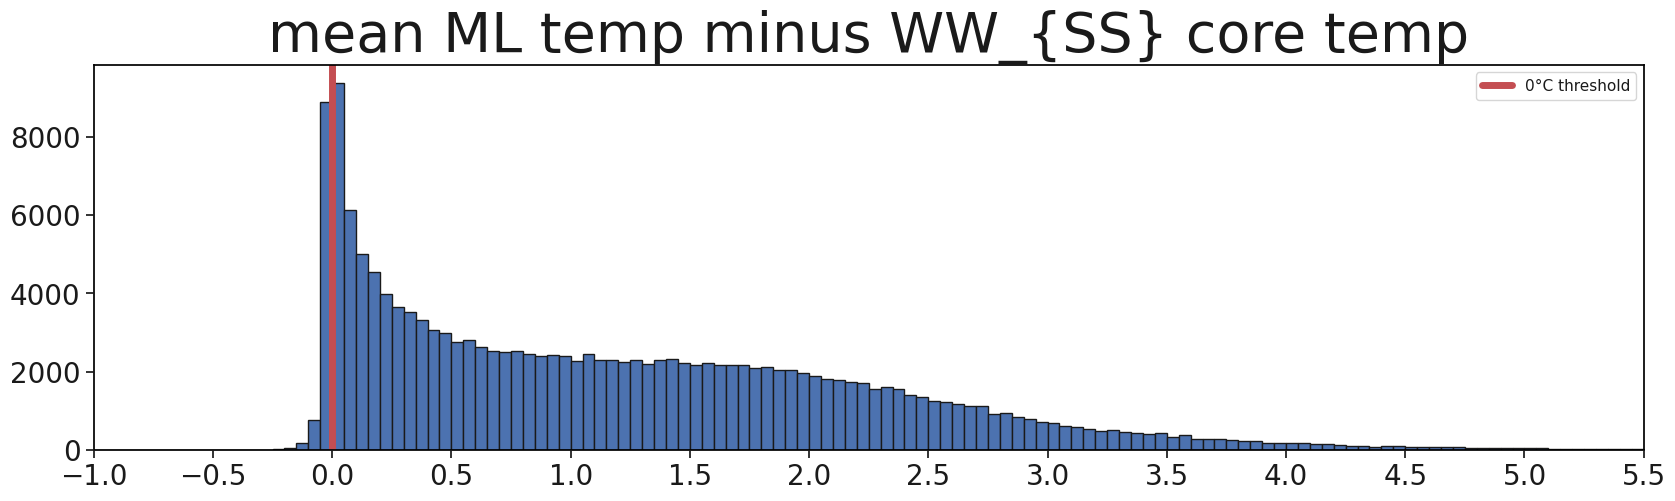

In [139]:
plt.figure(figsize=(20,5))
hst = plt.hist(tmp.ml_t - tmp.ww_ct,bins=np.arange(-1,7,0.05)) 
_=plt.xticks(np.arange(-1,7,0.5))
x = 0
plt.axvline(x,c='r',lw=5,label=f'{x}°C threshold')
plt.title('mean ML temp minus WW_{SS} core temp')
plt.xlim(-1,5.5)
_=plt.legend()


(array([  9923., 151345.]),
 array([0., 1., 2.]),
 <BarContainer object of 2 artists>)

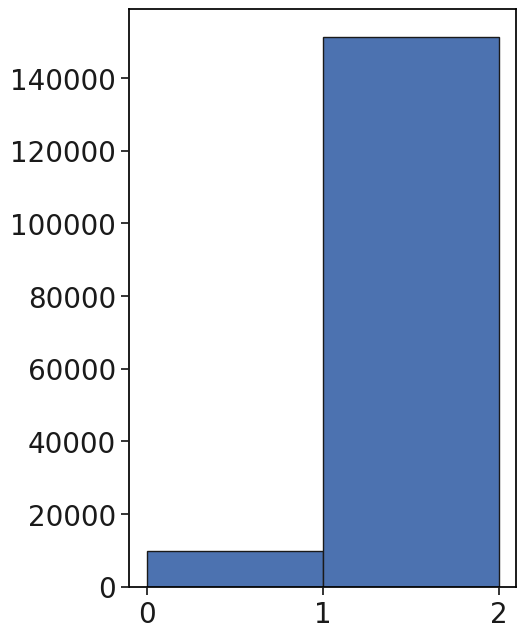

In [134]:
plt.figure(figsize=(5,7.5))
plt.hist(tmp.ml_t > tmp.ww_ct,np.arange(0,3,1)) 

In [96]:
(hst[0]).astype(int)

array([   0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    0,
          1,    0,    6,    6,   25,   58,  170,  759, 8897, 9374, 6137,
       5004, 4535, 3985, 3648, 3512, 3327, 3068, 2976, 2744, 2805, 2621,
       2515, 2496, 2514, 2455, 2407, 2413, 2407, 2272, 2456, 2287, 2290,
       2248, 2291, 2201, 2288, 2328, 2218, 2169, 2213, 2158, 2171, 2177,
       2087, 2106, 2044, 2048, 1953, 1897, 1821, 1795, 1725, 1706, 1560,
       1599, 1548, 1402, 1345, 1242, 1233, 1170, 1132, 1124,  915,  942,
        844,  778,  703,  688,  616,  586,  539,  474,  511,  456,  433,
        396,  437,  335,  368,  284,  273,  283,  261,  213,  213,  185,
        173,  172,  164,  136,  144,  131,   96,  102,   79,   93,   93,
         74,   68,   78,   62,   67,   41,   48,   47,   35,   46,   34,
         35,   30,   31,   23,   25,   24,   26,   14,   11,   12,    9,
          8,   16,    8,    2,    9,    9,    7,    6,    6,    7,    6,
          6,    2,    4,    4,    3,    3,    1,   

In [105]:
np.sum(hst[0][:25])

38958.0

In [104]:
np.sum(hst[0][25:])

122296.0

In [99]:
np.where(np.round(hst[1],2)==0.25)

(array([25]),)

In [97]:
np.round(hst[1],2)

array([-1.  , -0.95, -0.9 , -0.85, -0.8 , -0.75, -0.7 , -0.65, -0.6 ,
       -0.55, -0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15,
       -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,
        0.35,  0.4 ,  0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,
        0.8 ,  0.85,  0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,
        1.25,  1.3 ,  1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,
        1.7 ,  1.75,  1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,
        2.15,  2.2 ,  2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,
        2.6 ,  2.65,  2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,
        3.05,  3.1 ,  3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,
        3.5 ,  3.55,  3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,
        3.95,  4.  ,  4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,
        4.4 ,  4.45,  4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,
        4.85,  4.9 ,  4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,
        5.3 ,  5.35,

In [56]:
idx = np.where(tmp.ml_t - tmp.ww_ct < 0)[0]

In [57]:
idx.size

7989

In [59]:
tmp2 = tmp.isel(n_prof=idx)

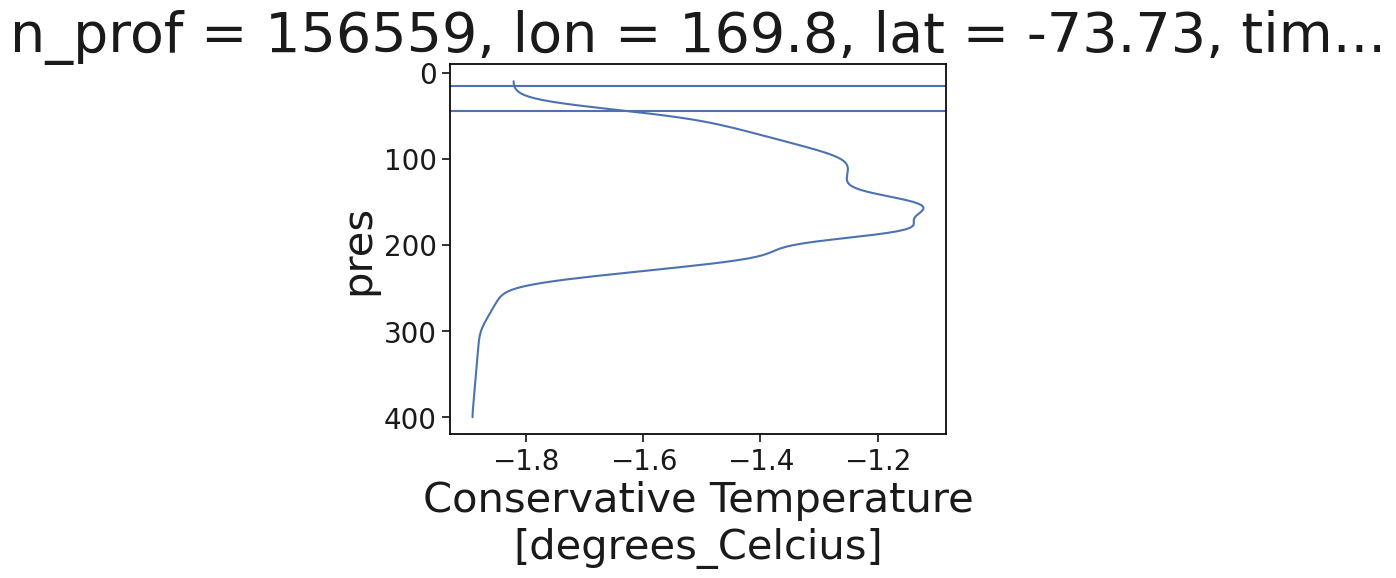

In [127]:
_=tmp2.ctemp.plot(y='pres')
plt.axhline(tmp2.up_bd)
plt.axhline(tmp2.lw_bd)
plt.gca().invert_yaxis()

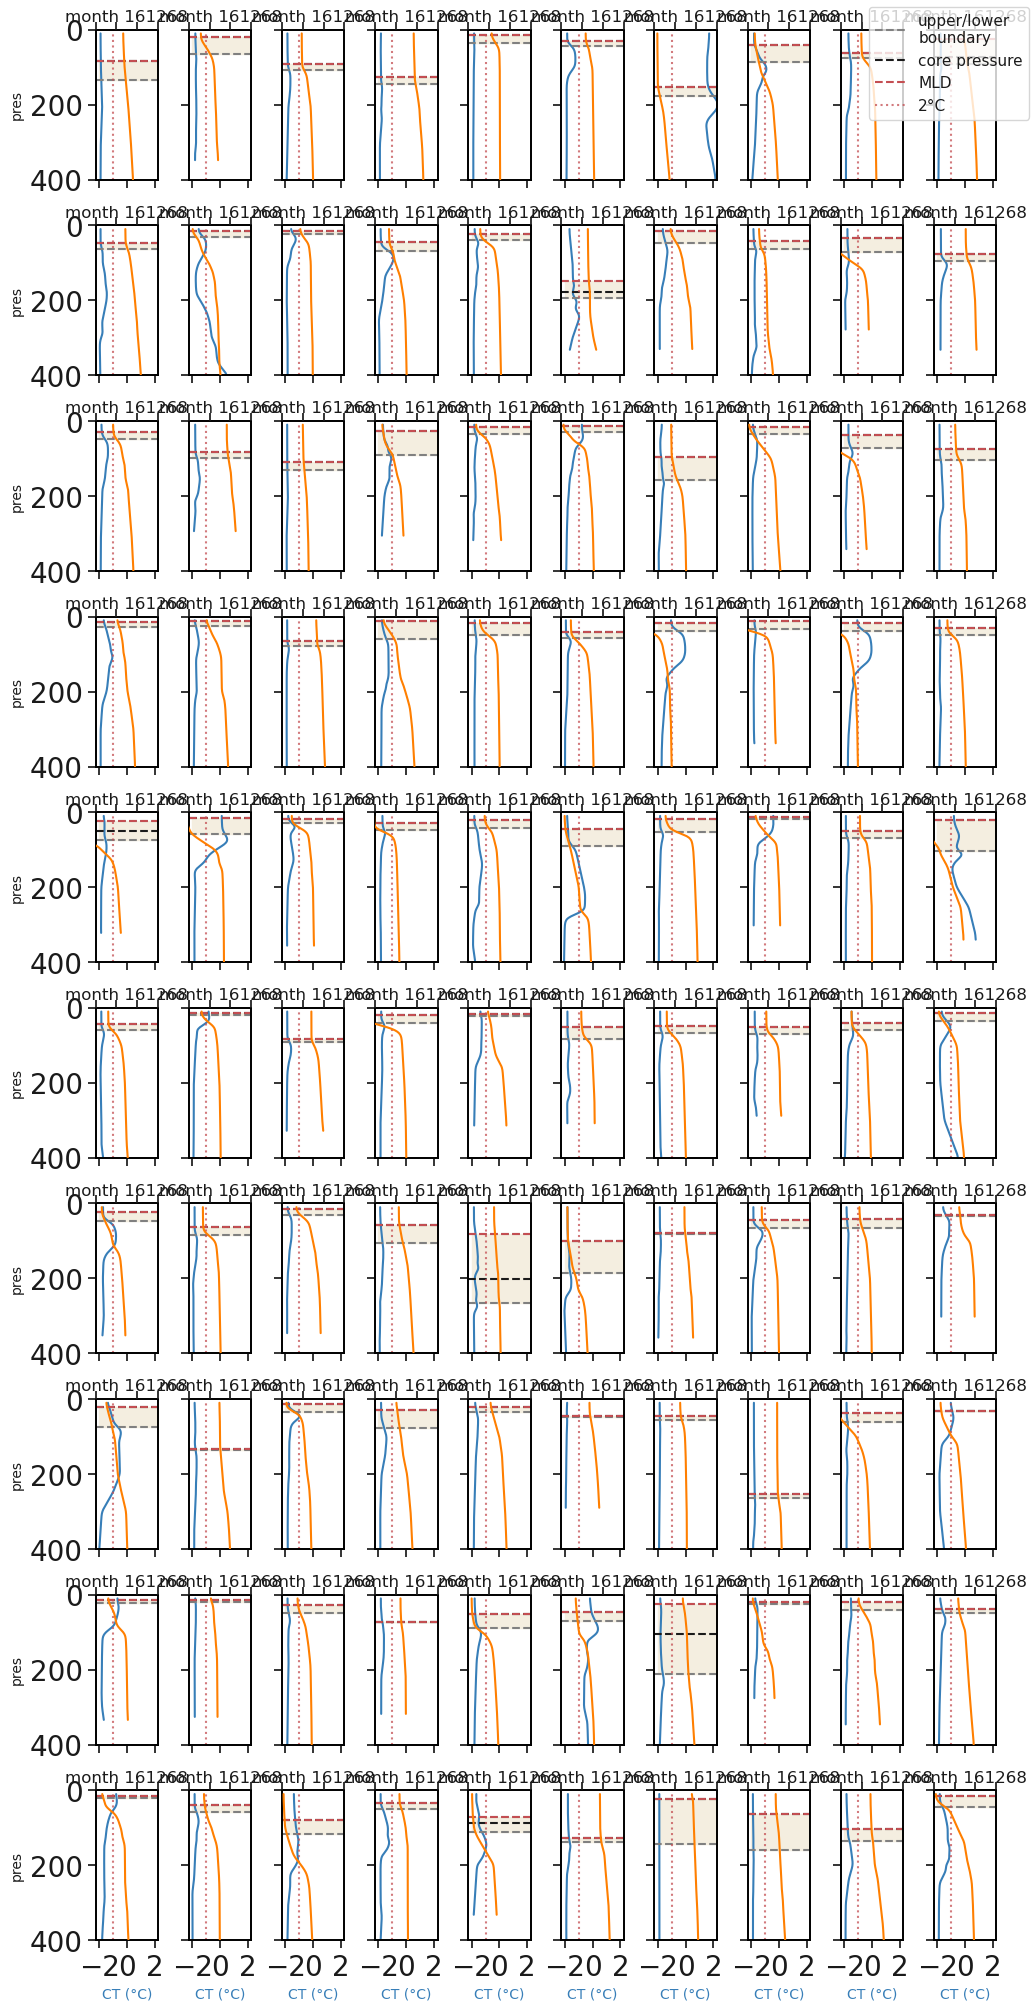

In [71]:
from random import randint

# set axes colours
c1 = '#377eb8'
c2 = '#ff7f00'

r = 10 # rows in figure
c = 10  # columns in figure

fig,ax = plt.subplots(r,c,figsize=[10,20],constrained_layout=True,sharex='col',sharey='row',#dpi=300
                     )
ax=ax.flatten()


# choose 30 random type 1 profiles from months 1-3 (where the most errenous profiles may occur)
idx2 = []
for j in range(100):
    idx2 += randint(0,idx.size-1),


for k,a in enumerate(ax):
    tmp2 = tmp.isel(n_prof=idx[idx2[k]])

    tmp2.ctemp.plot(y='pres',ax=a,c=c1,lw=1.5)
    l1 = a.axes.axhline(tmp2.up_bd,ls='--',c='grey')
    l2 = a.axes.axhline(tmp2.lw_bd,ls='--',c='grey')
    l3 = a.axes.axhline(tmp2.ww_cp,ls='--',c='k')
    l4 = a.axes.axhline(tmp2.mlp,ls='--',c='r')
    l5 = a.axes.axvline(-1,ls=':',c='r',alpha=0.75)

    a.axes.invert_yaxis()
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xlim(-2.25,2.25)

    a.set_xticks([-2,0,2])
    ww = a.fill_between(x=np.arange(-2,6,0.1),y1=tmp2.up_bd,y2=tmp2.lw_bd,color='#f4eee0')

    a.set_ylim(400,0)
    a.set_title(f'month {i+1}',fontsize=12)
    a.xaxis.label.set_color(c1)


    # twin axis and plot density
    a1 = a.twiny()
    (tmp2.rho-1027).plot(y='pres',zorder=5,ax=a1,c=c2,)
    a1.set_xlim(0,1.5)
    a1.set_xticks(np.arange(0,2,0.5))
    a1.set_title('')

    a1.tick_params(axis='both',which='major',)
    a1.xaxis.label.set_color(c2)
    if i==0 and k in range(c):
        a1.set_xlabel('rho-1027.5',fontsize=10,)
        a1.set_xticklabels(['0','0.5','1','1.5'],c=c2)
    else:
        a1.set_xlabel('')
        a1.set_xticklabels([])
    
for i,a in enumerate(ax[::c]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-c:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.legend([l1,l3,l4,l5],['upper/lower\nboundary','core pressure','MLD','2°C'])

#fig.suptitle('100 random "bad" temp profiles for JFM',fontsize=20)

# check vertical structure of temperature profiles

In [3]:
ds = xr.open_dataset('/home/theospira/notebooks/projects/WW_climatology/data/hydrographic_profiles/ww_gauss_smoothed_ds.nc')

In [4]:
def ml_temp_diff(ds):
    """
    Function: ml_temp_diff
    
    This function checks for differences in temperature between the mixed layer (ML) and the subsurface in a given dataset.
    It calculates the absolute temperature difference between the ML and subsurface profiles for each profile in the dataset.
    
    Parameters:
        ds (xarray.Dataset): The dataset containing temperature profiles and SS WW profiles only (!!!).
    
    Returns:
        ds (xarray.Dataset): The dataset with an added variable 'ct_df' representing the temperature differences.
    
    Usage:
    1. Import necessary libraries:
       import numpy as np
       import xarray as xr
       from tqdm import tqdm
    
    2. Define the function 'ml_temp_diff'.
    
    3. Initialize an empty array 'ct_df' to store temperature differences.
    
    4. Loop through each profile in the dataset to calculate temperature differences.
        - Create a subset 'tmp2' containing temperature profiles for the current profile.
        - Calculate the temperature difference between the ML and subsurface.
        - Store the result in the 'ct_df' array.
    
    5. Add the 'ct_df' variable to the dataset 'ds'.
    
    6. Return the modified dataset 'ds'.
    
    Example Usage:
    # Load your dataset
    # Example: ds = xr.open_dataset('your_data.nc')
    
    # Call the function to calculate temperature differences
    # ds = ml_temp_diff(ds)
    """

    # Initialize an array to store temperature differences
    ct_df = np.ndarray(ds.ctemp.shape) * np.nan

    # Loop through each profile in the dataset
    for i in tqdm(range(ds.n_prof.size)):
        # Extract the necessary data for the current profile
        tmp2 = ds.isel(n_prof=i)[['ctemp', 'mlp']]

        # Calculate the absolute temperature difference between ML and subsurface
        ct_df[i, :] = (np.abs(tmp2.ctemp - tmp2.ctemp.sel(pres=slice(0, tmp2.mlp.data)).mean(skipna=True))).values

    # Add the 'ct_df' variable to the dataset
    ds['ct_df'] = xr.DataArray(ct_df, dims={'n_prof': ds.n_prof.data, 'pres': ds.pres.data},
                               coords={'n_prof': ds.n_prof.data, 'pres': ds.pres.data})

    return ds


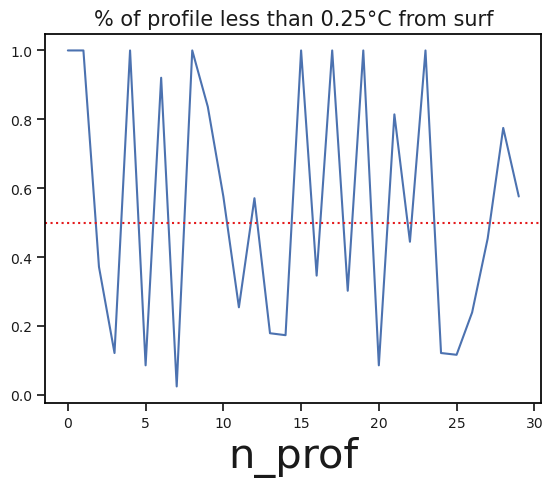

In [11]:
x = 0.5 # threshold value

# check number of data points with a change lower than 0.02 (uncertainty) as a %age of the total data points
((chk.ct_df < 0.25).sum('pres')/chk.ctemp.notnull().sum('pres')).plot()
plt.axhline(x,c='#e41a1c',ls=':')
plt.title('% of profile less than 0.25°C from surf',fontsize=15)
plt

idx = ((chk.ct_df < 0.25).sum('pres')/chk.ctemp.notnull().sum('pres')) > x

In [9]:
ds = ml_temp_diff(ds.isel(n_prof=np.where(ds.ww_type.notnull())[0]))

  0%|          | 0/266856 [00:00<?, ?it/s]

### do some checks on below first before dropping all profiles. find the index, plot the profiles. get histogram version of line graph below

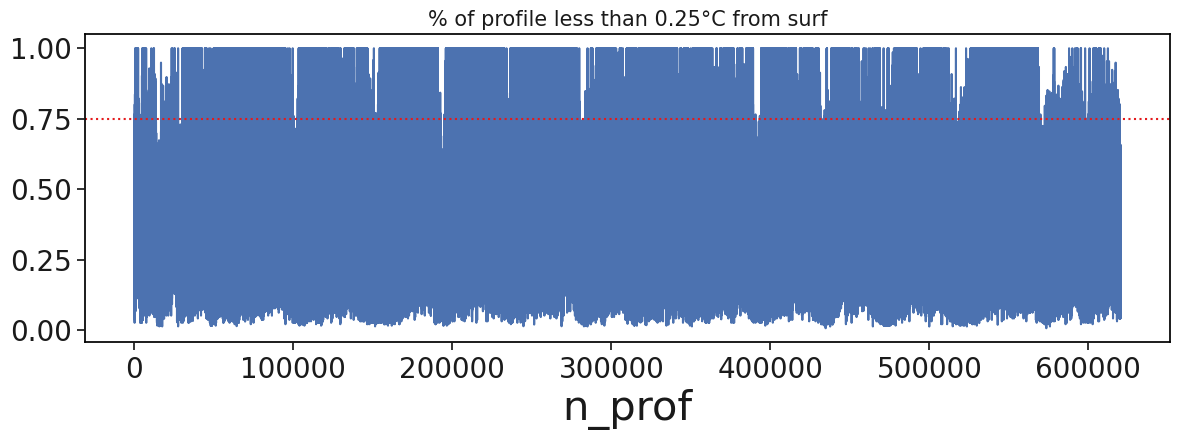

In [16]:
x = 0.75 # threshold value

# check number of data points with a change lower than 0.02 (uncertainty) as a %age of the total data points
((ds.ct_df < 0.25).sum('pres')/ds.ctemp.notnull().sum('pres')).plot(figsize=(14,4))
plt.axhline(x,c='#e41a1c',ls=':')
plt.title('% of profile less than 0.25°C from surf',fontsize=15)

idx = ((ds.ct_df < 0.25).sum('pres')/ds.ctemp.notnull().sum('pres')) > x

In [13]:
tmp = ((ds.ct_df < 0.25).sum('pres')/ds.ctemp.notnull().sum('pres'))

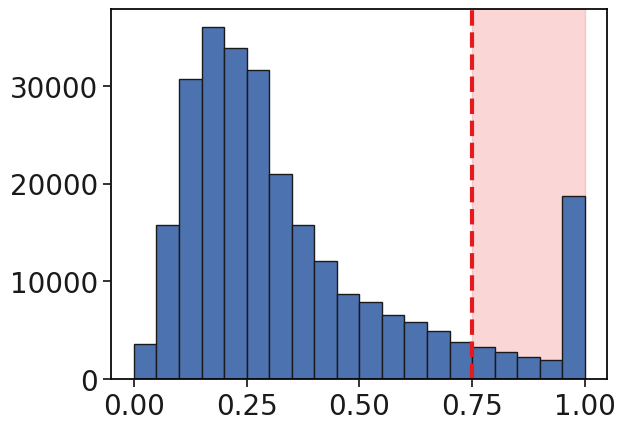

In [26]:
tmp.plot.hist(bins=np.arange(0,1.05,0.05),zorder=1)
plt.axvline(x,c='#e41a1c',ls='--',lw=3,)
plt.axvspan(ymax=35e3,xmin=x,xmax=1.,color='#ed5e5f',alpha=0.25,zorder=0)

In [ ]:
idx = ((ds.ct_df < 0.25).sum('pres')/ds.ctemp.notnull().sum('pres')) > x

In [28]:
idx = np.where(tmp > x)[0]

Text(0.5, 0.98, '30 random temperature and density profiles')

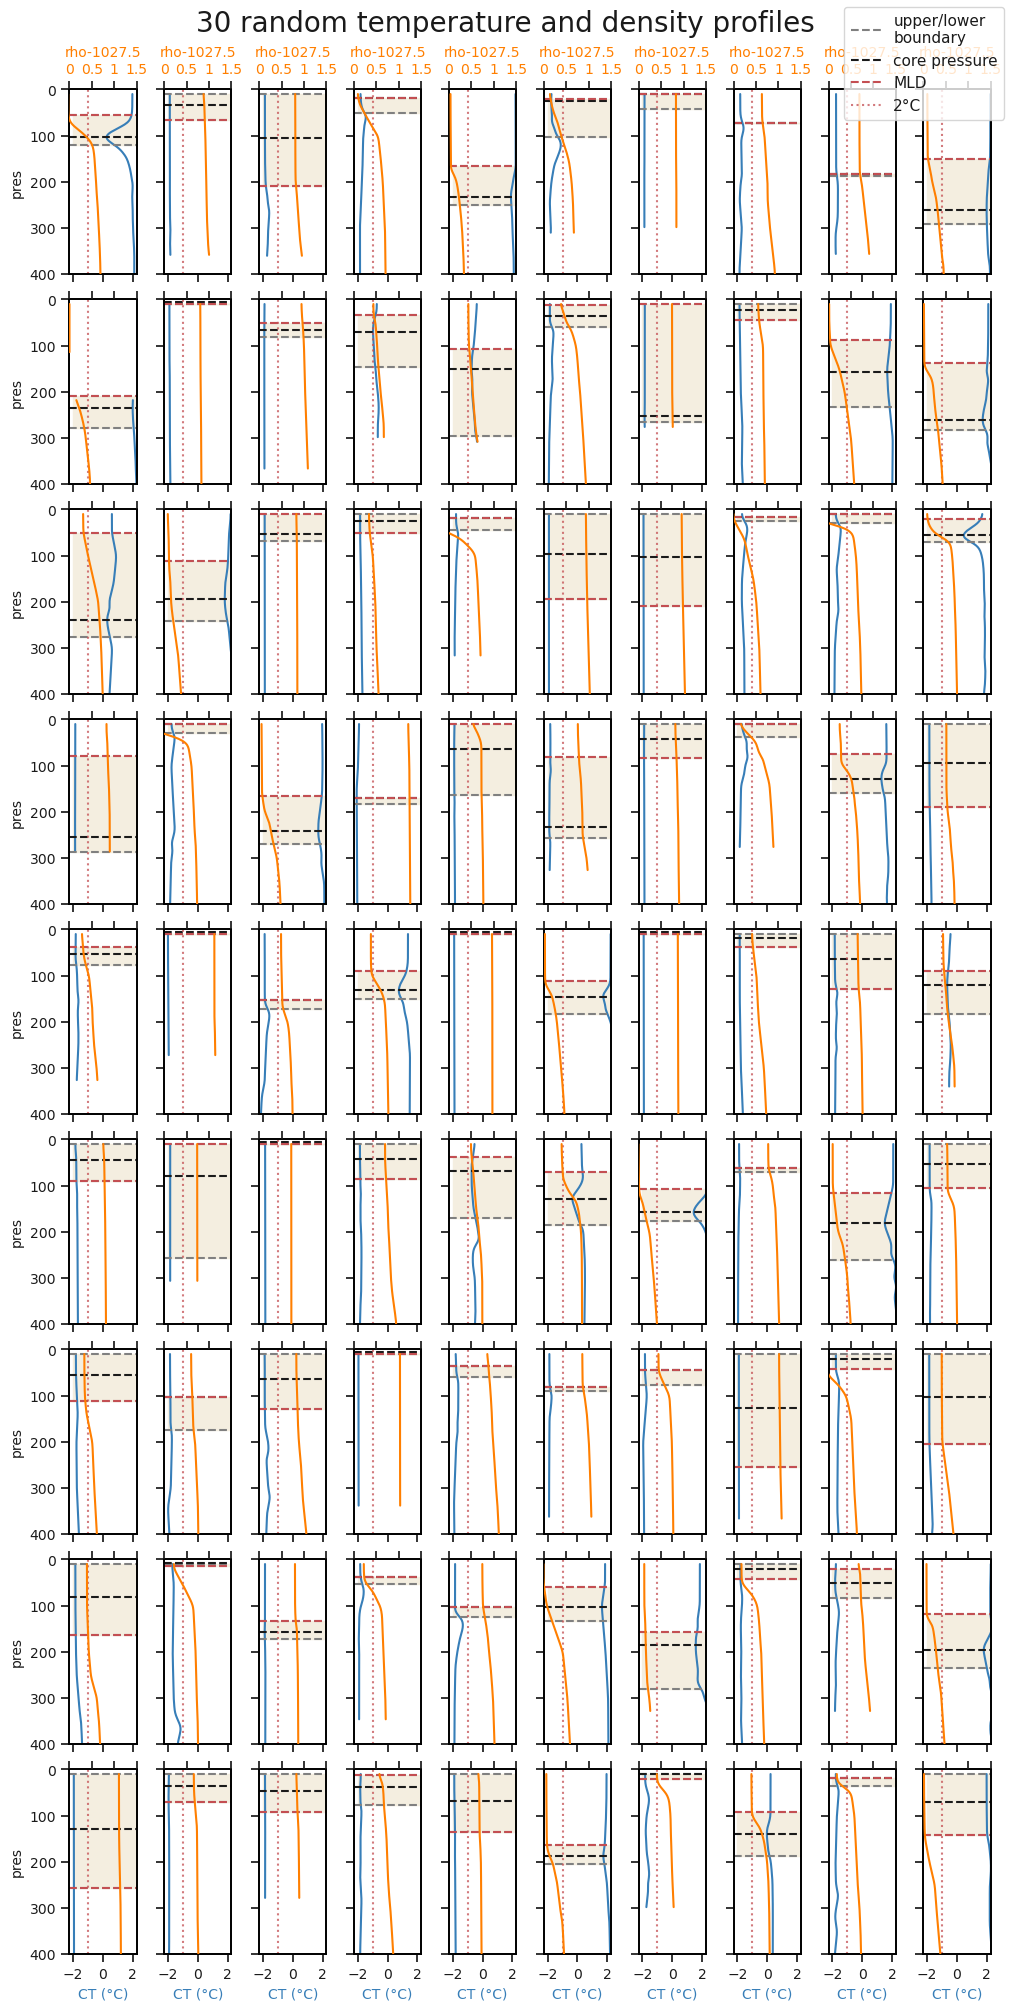

In [29]:
from random import randint

# set axes colours
c1 = '#377eb8'
c2 = '#ff7f00'

r = 9 # rows in figure
c = 10  # columns in figure

fig,ax = plt.subplots(r,c,figsize=[10,20],constrained_layout=True,sharex='col',sharey='row',#dpi=300
                     )
ax=ax.flatten()

for i in range(3):
    # choose 30 random profiles
    idx2 = []
    for j in range(30):
        idx2 += randint(0,idx.size-1),
    chk = ds.isel(n_prof=idx[idx2])
    
    for k,a in enumerate(ax[i*30:(i+1)*30]):
        tmp2 = chk.isel(n_prof=k)

        tmp2.ctemp.plot(y='pres',ax=a,c=c1,lw=1.5)
        l1 = a.axes.axhline(tmp2.up_bd,ls='--',c='grey')
        l2 = a.axes.axhline(tmp2.lw_bd,ls='--',c='grey')
        l3 = a.axes.axhline(tmp2.ww_cp,ls='--',c='k')
        l4 = a.axes.axhline(tmp2.mlp,ls='--',c='r')
        l5 = a.axes.axvline(-1,ls=':',c='r',alpha=0.75)

        a.axes.invert_yaxis()
        a.set_xlabel('')
        a.set_ylabel('')
        a.set_xlim(-2.25,2.25)

        a.set_xticks([-2,0,2])
        ww = a.fill_between(x=np.arange(-2,6,0.1),y1=tmp2.up_bd,y2=tmp2.lw_bd,color='#f4eee0')

        a.set_ylim(400,0)
        a.set_title('')
        a.xaxis.label.set_color(c1)
        a.tick_params(axis='both',which='major',labelsize=10)
        
        
        # twin axis and plot density
        a1 = a.twiny()
        (tmp2.rho-1027).plot(y='pres',zorder=5,ax=a1,c=c2,)
        a1.set_xlim(0,1.5)
        a1.set_xticks(np.arange(0,2,0.5))
        a1.set_title('')
    
        a1.tick_params(axis='both',which='major',labelsize=10)
        a1.xaxis.label.set_color(c2)
        if i==0 and k in range(c):
            a1.set_xlabel('rho-1027.5',fontsize=10,)
            a1.set_xticklabels(['0','0.5','1','1.5'],c=c2,fontsize=10)
        else:
            a1.set_xlabel('')
            a1.set_xticklabels([])
    
for i,a in enumerate(ax[::c]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-c:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.legend([l1,l3,l4,l5],['upper/lower\nboundary','core pressure','MLD','2°C'])

fig.suptitle('30 random temperature and density profiles',fontsize=20)

(array([23399., 56584., 73541., 74426., 62241., 57584., 40017., 30816.,
        24375., 18282., 17288., 14772., 13006., 11122.,  8789.,  8451.,
         7478.,  6274.,  5567.,  2958., 35976.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05]),
 <BarContainer object of 21 artists>)

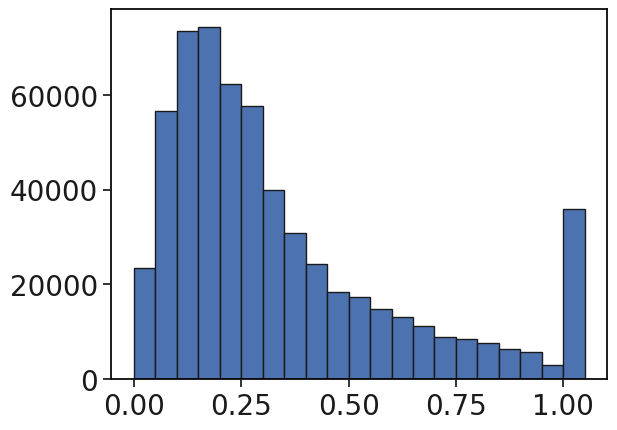

In [18]:
tmp.plot.hist(bins=np.arange(0,1.1,0.05))

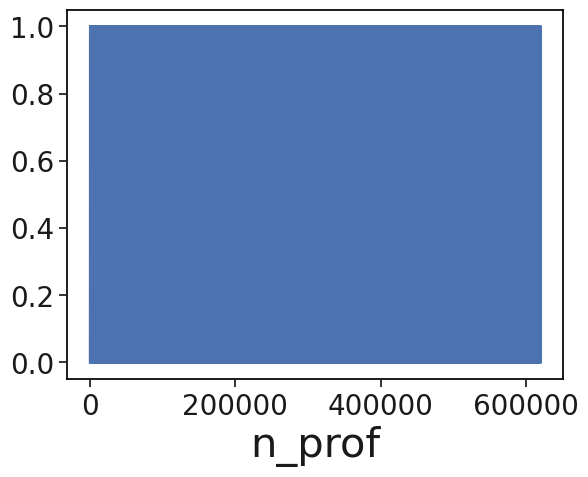

In [11]:
idx.plot()

In [8]:
idx.astype(int)

<xarray.DataArray (n_prof: 592946)>
array([0, 0, 0, ..., 0, 0, 0])
Coordinates:
  * n_prof   (n_prof) int64 0 1 2 3 4 5 ... 620288 620289 620290 620291 620292
    lon      (n_prof) float64 -47.64 -3.374 19.1 -57.59 ... 61.33 -106.7 156.9
    lat      (n_prof) float64 -57.46 -69.32 -58.43 ... -41.05 -42.42 -65.83
    time     (n_prof) datetime64[ns] 2004-01-01T10:01:28.999999744 ... 2021-1...

(array([463122.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 129824.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

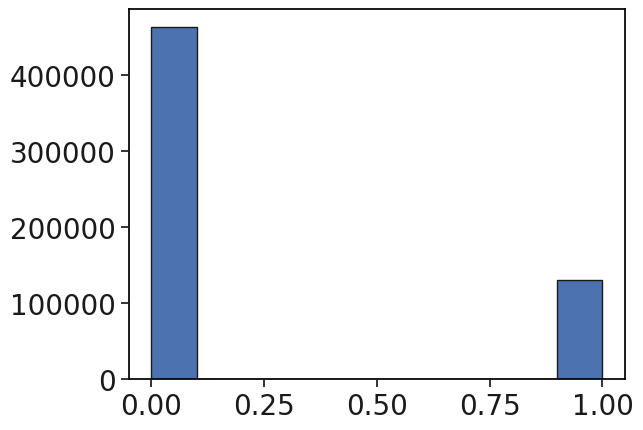

In [10]:
plt.hist(idx.astype(int))

In [ ]:
def vert_profs_QC(ds,x=0.5):
    """
    removes vertical profiles in temperature. 
    requires ct_df variable in dataset; that is, function ml_temp_diff needs to have run
    
    x is the percentage of profile that is > 0.25°C difference from ML temp.
    
    """

    idx = ((ds.ct_df < 0.25).sum('pres')/ds.ctemp.notnull().sum('pres')) > x
    idx = np.where(idx==1)[0]
    return ds = ds.drop_isel(n_prof=idx)

In [76]:
np.where(tmp.sig.isnull().sum('pres') > 150)[0].size

3

In [72]:
tmp.ww_type.notnull().sum()

<xarray.DataArray 'ww_type' ()>
array(266856)

In [75]:
tmp = ds.isel(n_prof=np.where(ds.ww_type.notnull())[0])
tmp = tmp.isel(n_prof=slice(0,10000))

tmp = ml_temp_diff(tmp)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [62]:
randint(0,ds)

<bound method Random.randint of <random.Random object at 0x563118fac0c0>>

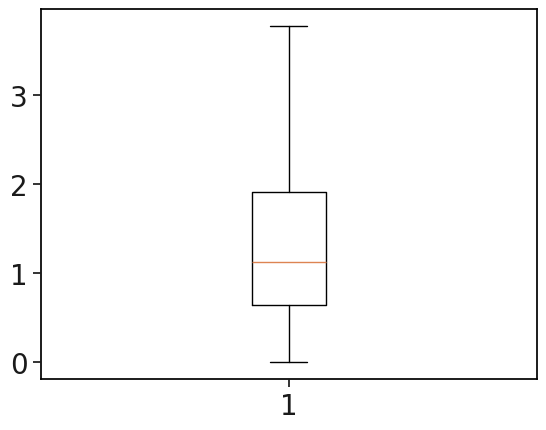

In [46]:
boxplot(tmp.ct_df.sum('pres') / tmp.ct_df.notnull().sum('pres'))

(array([ 72.,  83., 133., 174., 182., 224., 273., 315., 311., 301., 307.,
        365., 327., 374., 334., 340., 346., 319., 285., 271., 254., 255.,
        253., 222., 248., 223., 209., 207., 187., 205., 184., 141., 147.,
        141., 140., 149., 121., 132., 135., 135., 104.,  93.,  78.,  74.,
         72.,  77.,  58.,  50.,  43.,  32.,  36.,  29.,  27.,  16.,  24.,
         22.,  13.,  12.,  10.,  11.,   7.,   6.,   9.,   5.,   6.,   3.,
          4.,   0.,   8.,   2.,   7.,   3.,   5.,   5.,   6.,   3.,   0.,
          2.,   1.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200., 210.,
        220., 230., 240., 250., 260., 270., 280., 290., 300., 310., 320.,
        330., 340., 350., 360., 370., 380., 390., 400., 410., 420., 430.,
        440., 450., 460., 470., 480., 490., 500., 510., 520., 530., 540.,
        550., 560., 570., 580., 590., 600., 610., 620., 630., 640., 650.,
        660., 67

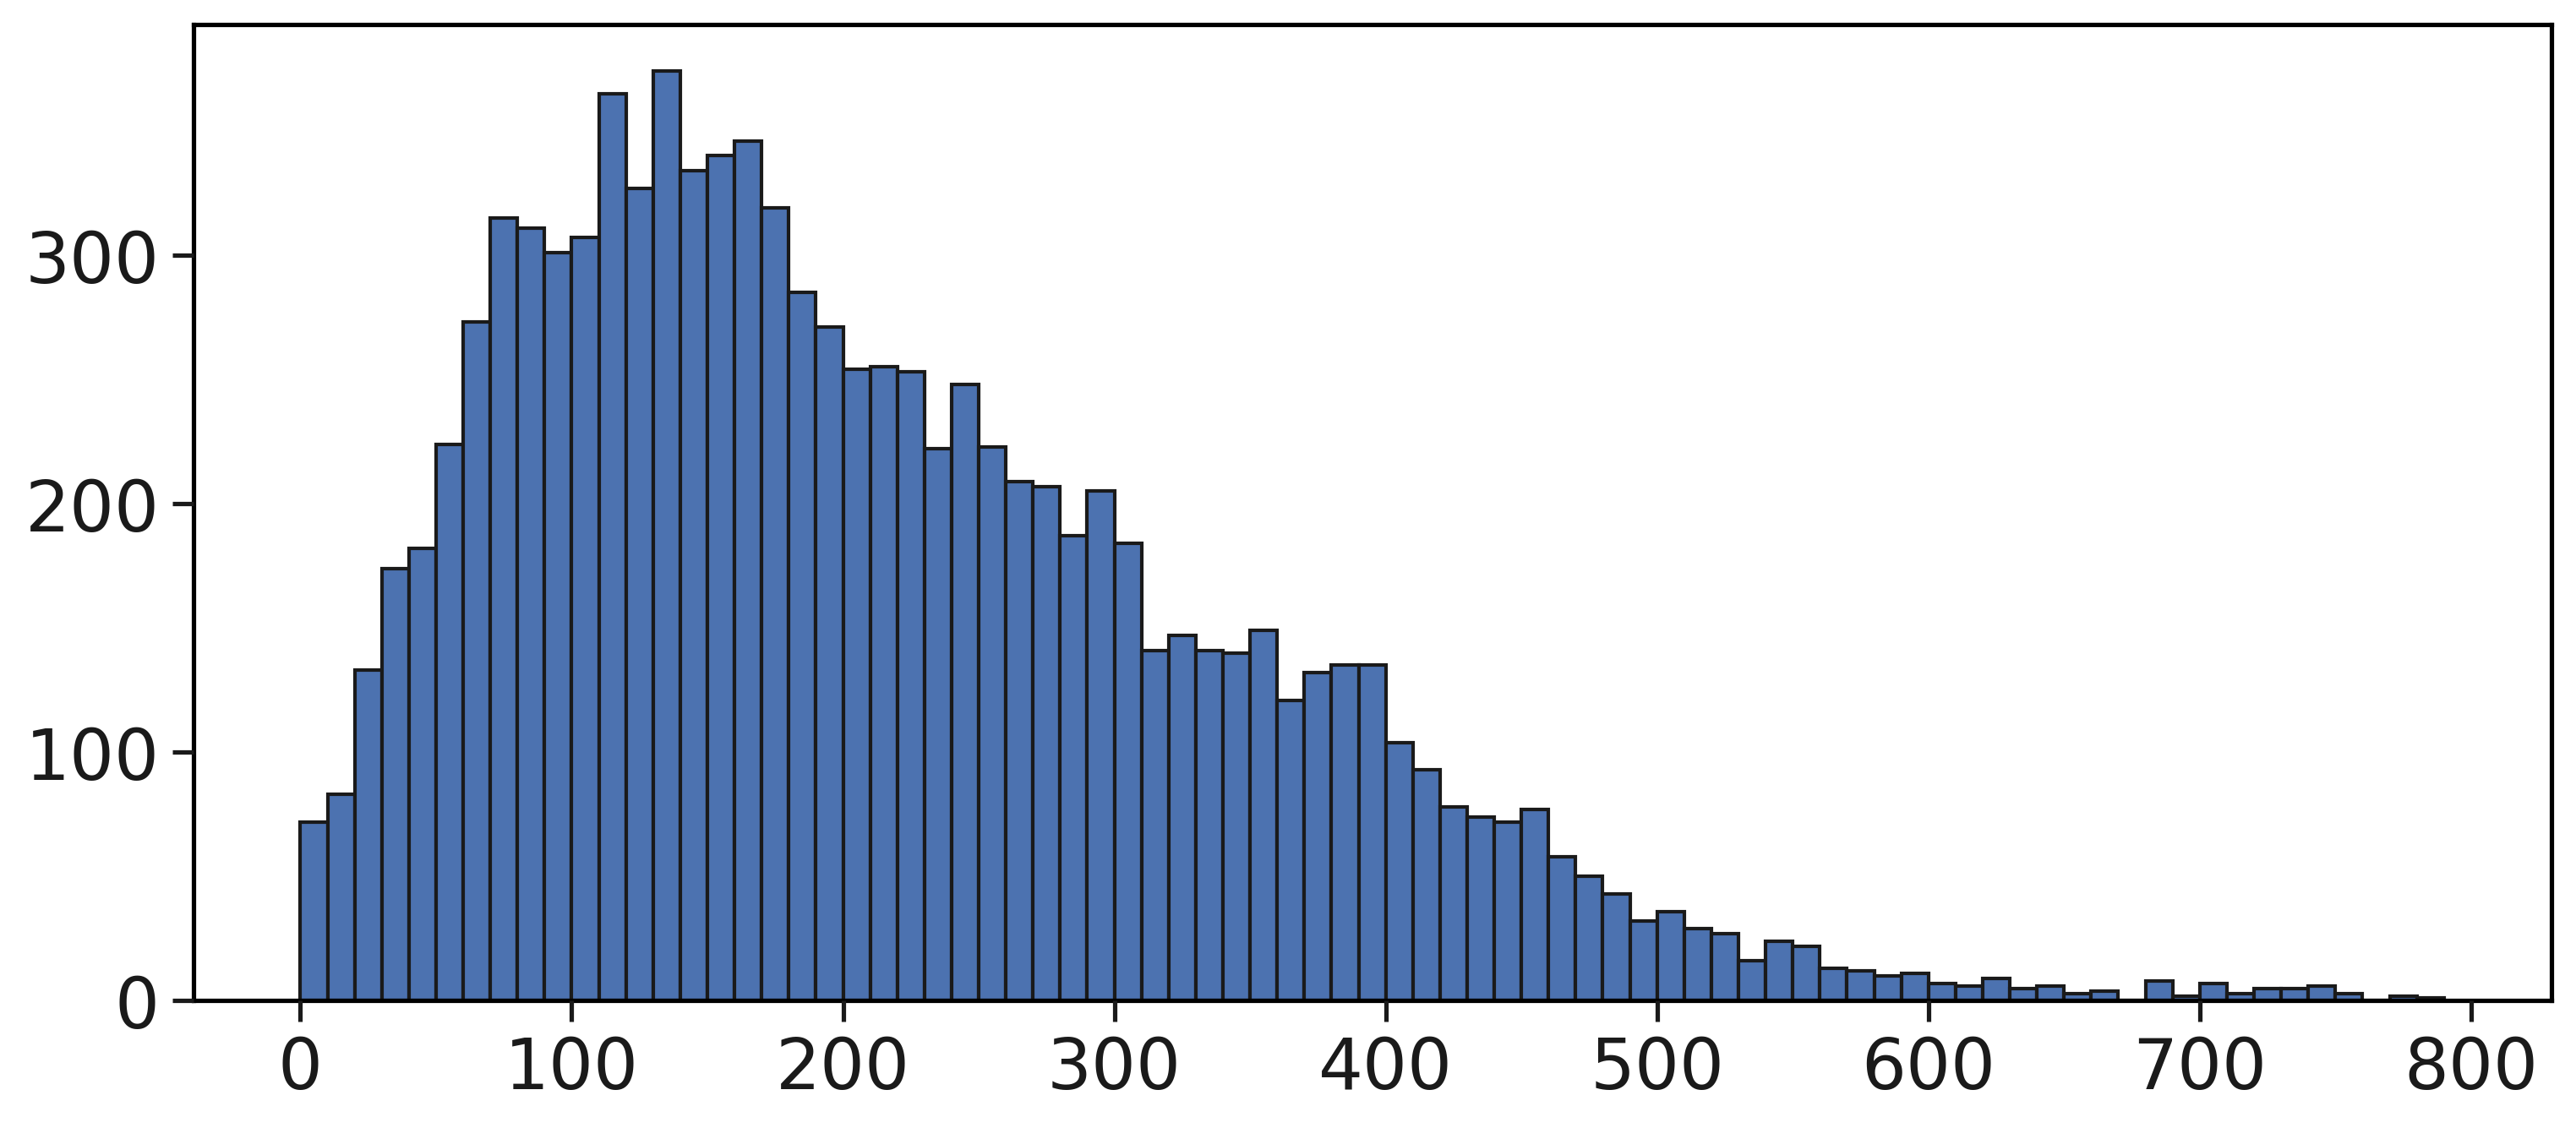

In [97]:
plt.figure(figsize=(12,5),dpi=300)
plt.hist(tmp.ct_df.sum('pres'),np.arange(0,800,10))

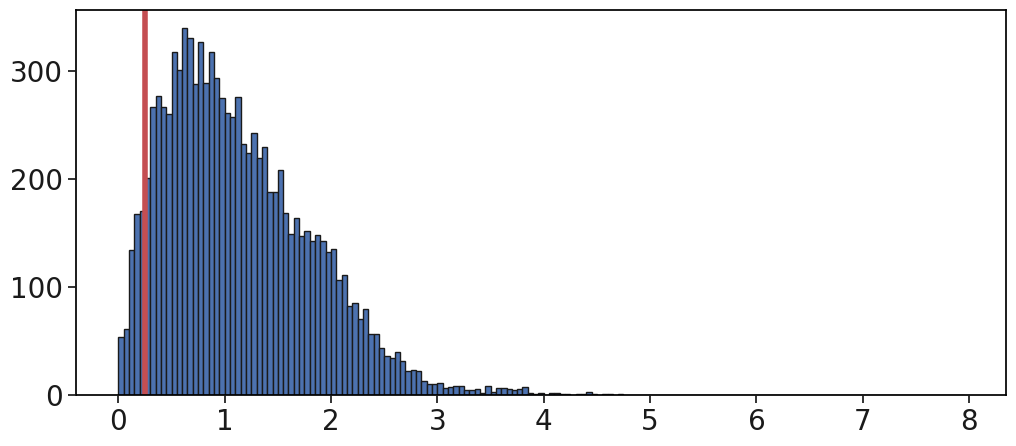

In [84]:
plt.figure(figsize=(12,5))
hist = plt.hist(tmp.ct_df.sum('pres') / tmp.ct_df.notnull().sum('pres'),np.arange(0,8,0.05))
_=plt.axvline(0.25,lw=4,c='r')

In [90]:
hist[0][:6].sum()

788.0

In [91]:
hist[0].sum()

10000.0

In [88]:
hist[1][:6]

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25])

In [79]:
np.where(tmp.ct_df.isnull().sum('pres')>100)[0].size

27

(array([8.245e+03, 1.170e+02, 3.680e+02, 3.780e+02, 3.640e+02, 3.330e+02,
        1.410e+02, 9.000e+00, 6.000e+00, 1.000e+01, 6.000e+00, 7.000e+00,
        6.000e+00, 4.000e+00, 3.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200.]),
 <BarContainer object of 20 artists>)

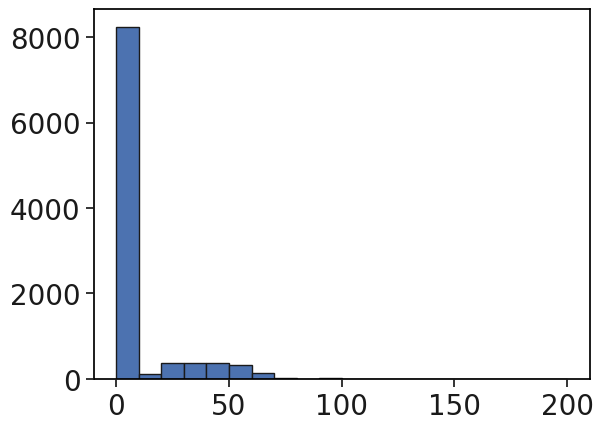

In [80]:
plt.hist(tmp.ct_df.isnull().sum('pres'),np.arange(0,210,10))

(array([6.912e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19.]),
 <BarContainer object of 19 artists>)

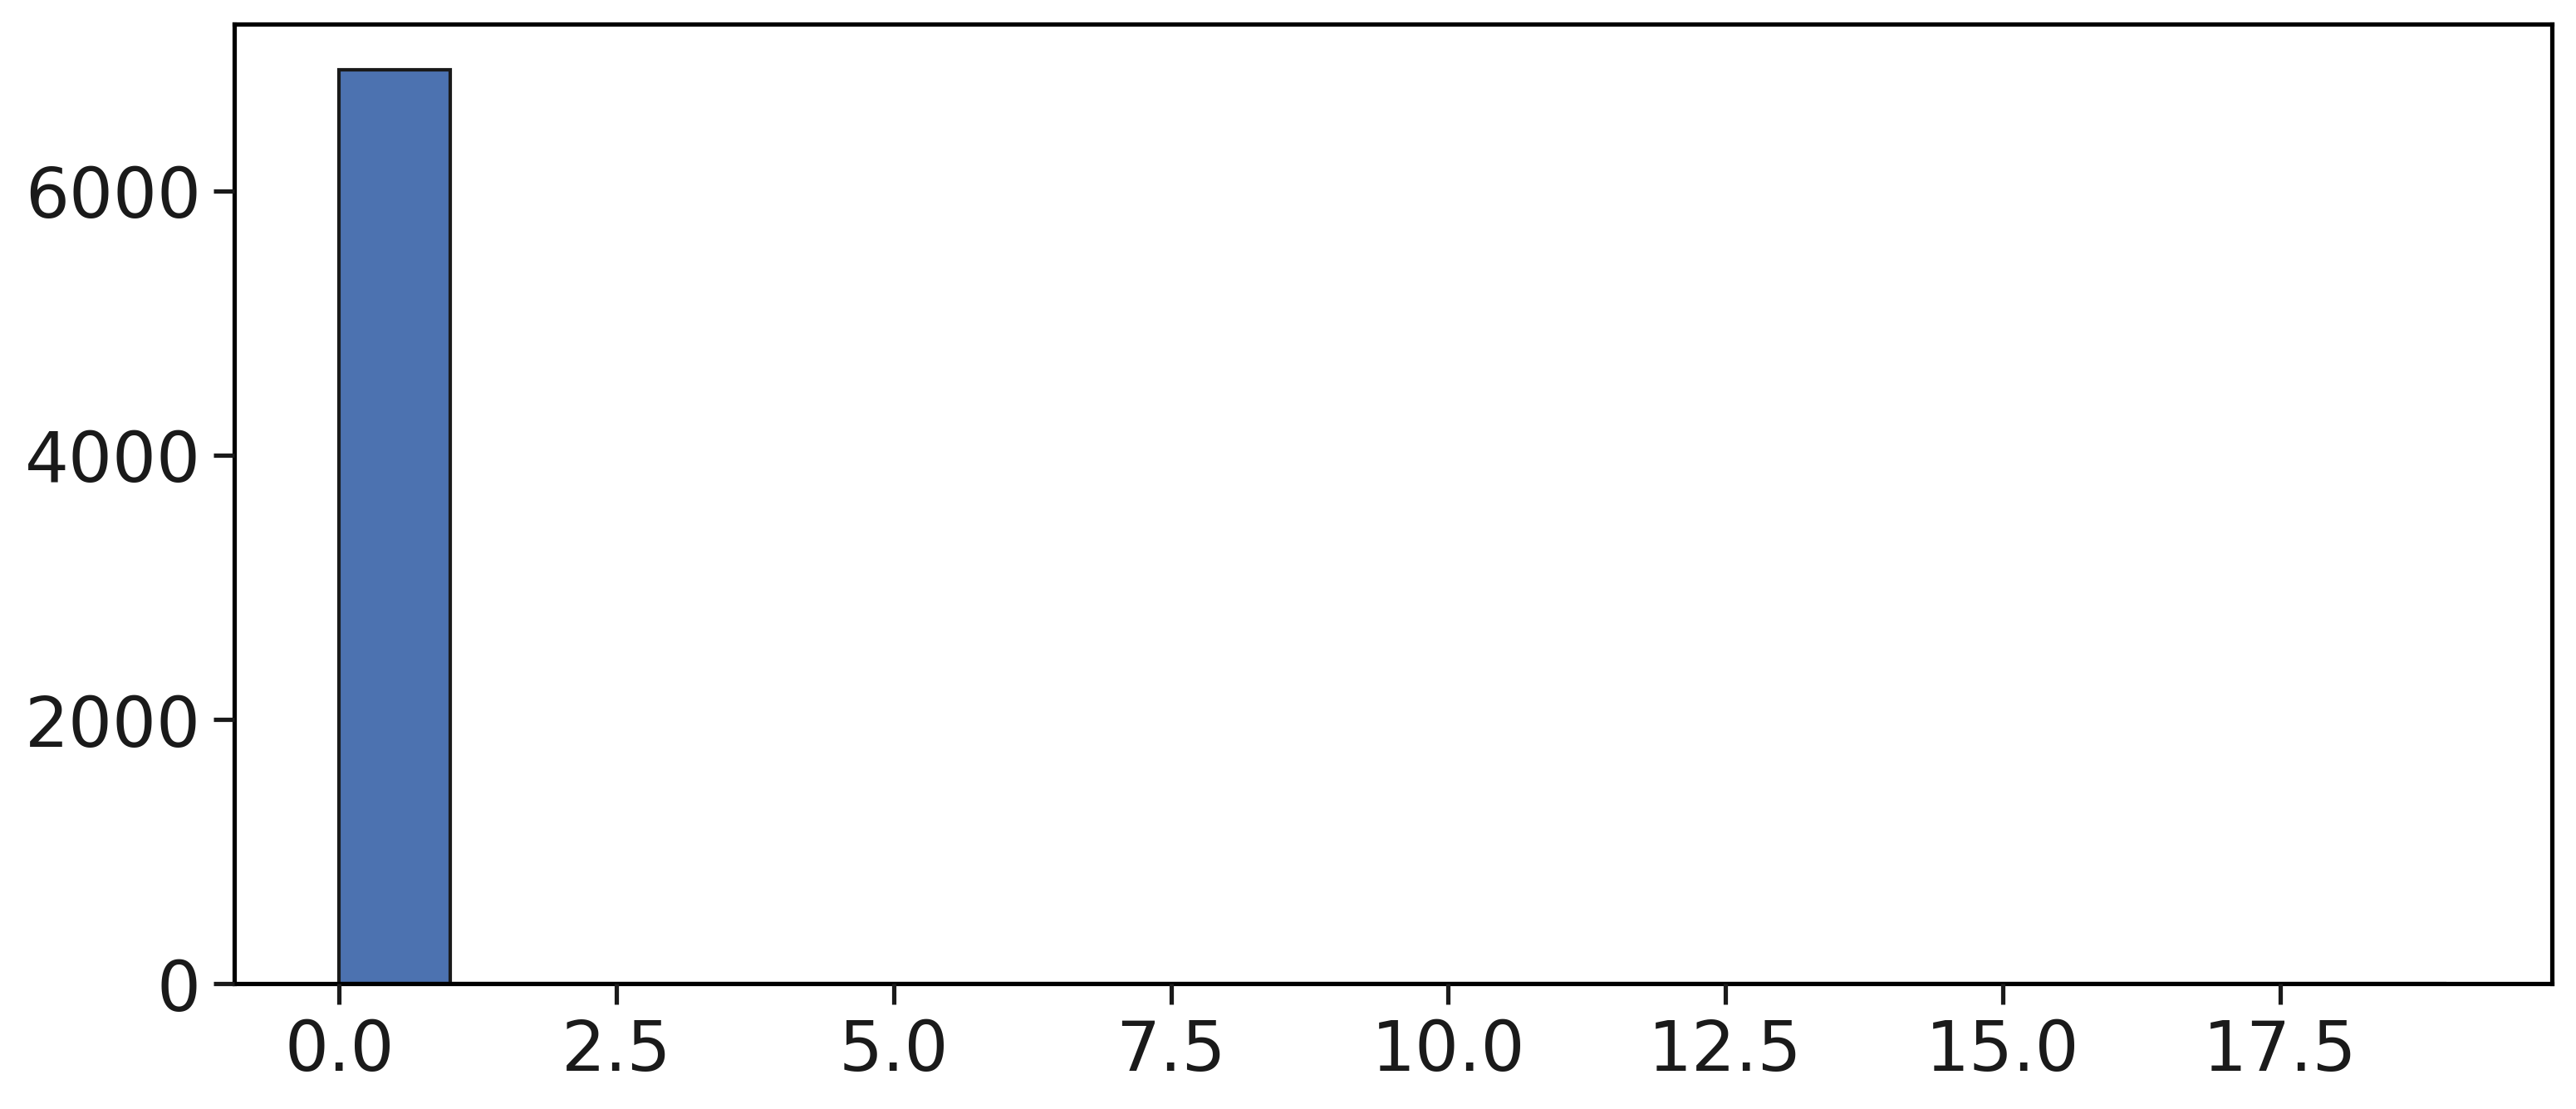

In [51]:
plt.figure(figsize=(12,5),dpi=300)
plt.hist(tmp.ct_df.notnull().sum('pres'),np.arange(0,20,1))

In [100]:
idx = np.where(tmp.ct_df.sum('pres') < 100)[0]

Text(0.5, 0.98, '30 random temperature and density profiles')

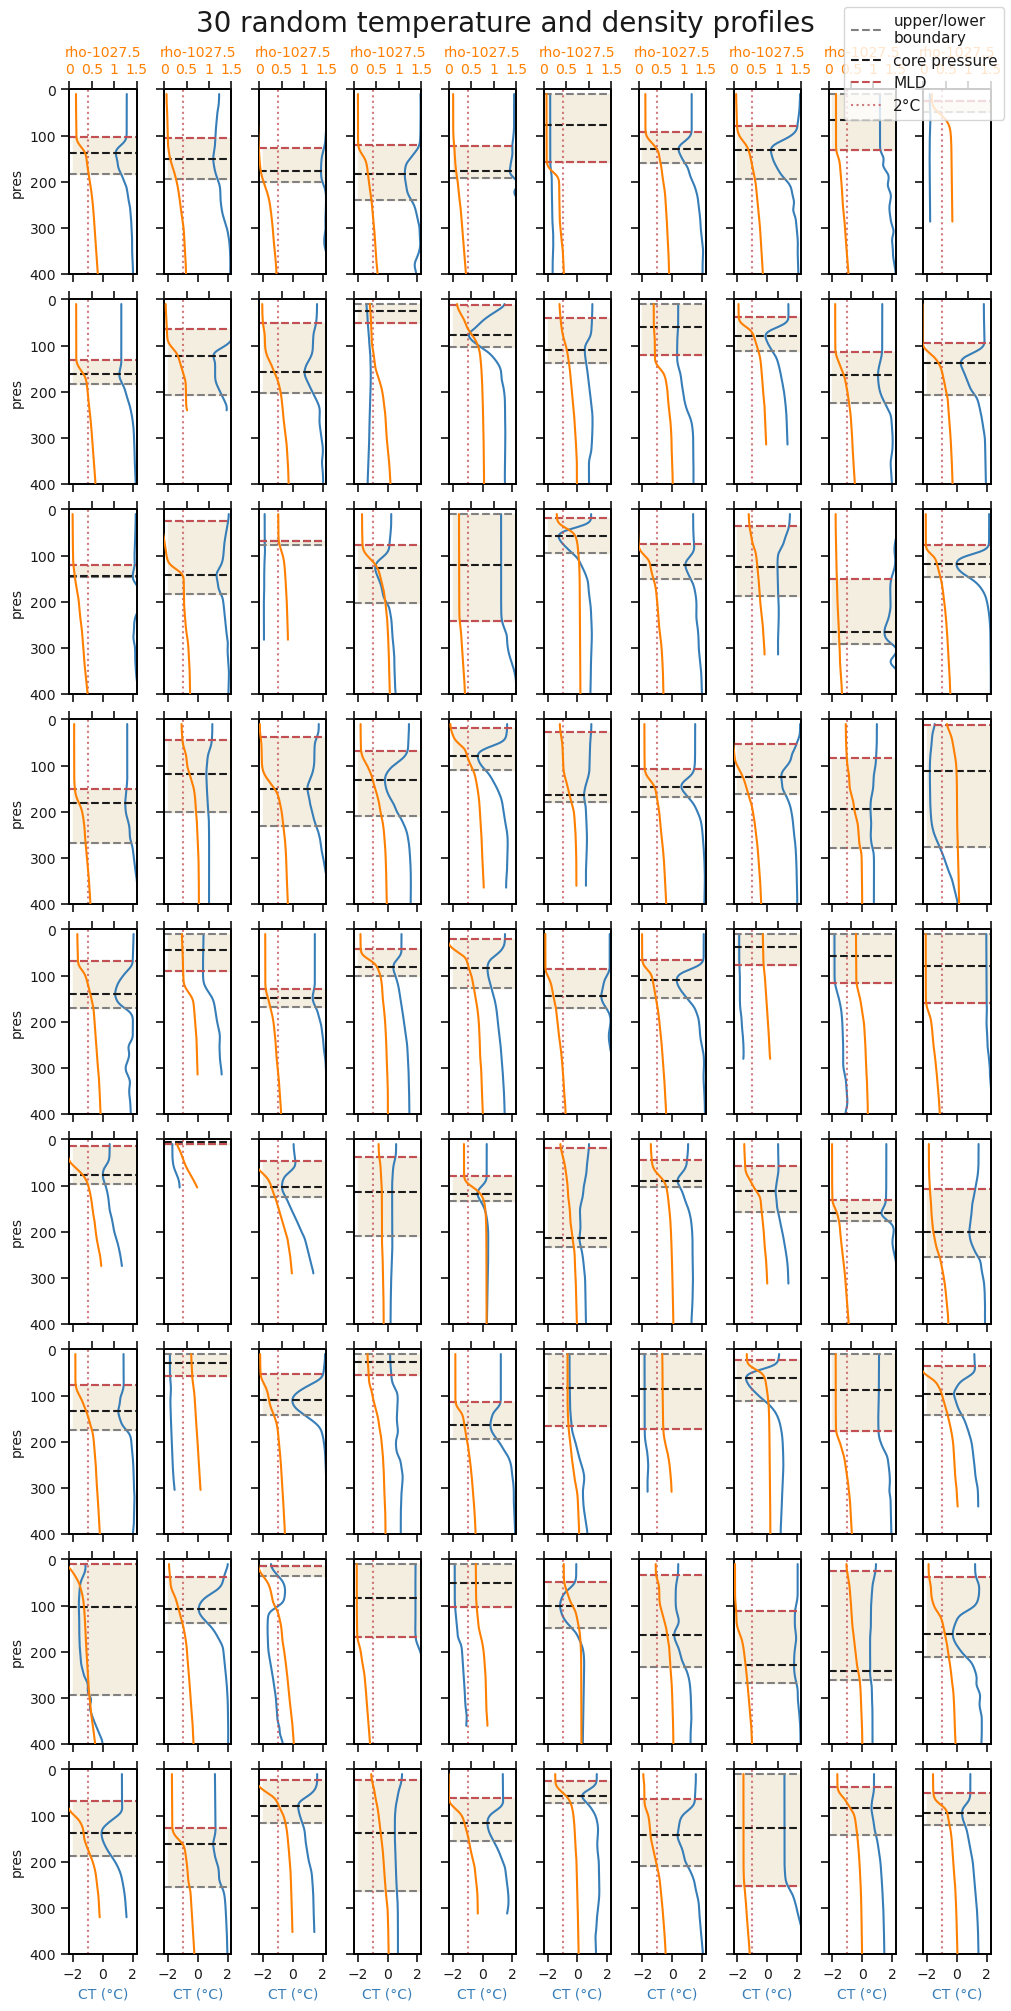

In [102]:
from random import randint

# set axes colours
c1 = '#377eb8'
c2 = '#ff7f00'

r = 9 # rows in figure
c = 10  # columns in figure

fig,ax = plt.subplots(r,c,figsize=[10,20],constrained_layout=True,sharex='col',sharey='row',#dpi=300
                     )
ax=ax.flatten()

for i in range(3):
    # choose 30 random profiles
    idx2 = []
    for j in range(30):
        idx2 += randint(0,idx.size-1),
    chk = tmp.isel(n_prof=idx[idx2])
    
    for k,a in enumerate(ax[i*30:(i+1)*30]):
        tmp2 = chk.isel(n_prof=k)

        tmp2.ctemp.plot(y='pres',ax=a,c=c1,lw=1.5)
        l1 = a.axes.axhline(tmp2.up_bd,ls='--',c='grey')
        l2 = a.axes.axhline(tmp2.lw_bd,ls='--',c='grey')
        l3 = a.axes.axhline(tmp2.ww_cp,ls='--',c='k')
        l4 = a.axes.axhline(tmp2.mlp,ls='--',c='r')
        l5 = a.axes.axvline(-1,ls=':',c='r',alpha=0.75)

        a.axes.invert_yaxis()
        a.set_xlabel('')
        a.set_ylabel('')
        a.set_xlim(-2.25,2.25)

        a.set_xticks([-2,0,2])
        ww = a.fill_between(x=np.arange(-2,6,0.1),y1=tmp2.up_bd,y2=tmp2.lw_bd,color='#f4eee0')

        a.set_ylim(400,0)
        a.set_title('')
        a.xaxis.label.set_color(c1)
        a.tick_params(axis='both',which='major',labelsize=10)
        
        
        # twin axis and plot density
        a1 = a.twiny()
        (tmp2.rho-1027).plot(y='pres',zorder=5,ax=a1,c=c2,)
        a1.set_xlim(0,1.5)
        a1.set_xticks(np.arange(0,2,0.5))
        a1.set_title('')
    
        a1.tick_params(axis='both',which='major',labelsize=10)
        a1.xaxis.label.set_color(c2)
        if i==0 and k in range(c):
            a1.set_xlabel('rho-1027.5',fontsize=10,)
            a1.set_xticklabels(['0','0.5','1','1.5'],c=c2,fontsize=10)
        else:
            a1.set_xlabel('')
            a1.set_xticklabels([])
    
for i,a in enumerate(ax[::c]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-c:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.legend([l1,l3,l4,l5],['upper/lower\nboundary','core pressure','MLD','2°C'])

fig.suptitle('30 random temperature and density profiles',fontsize=20)

In [119]:
x = 0.05

# how much of profile has a difference of less than 0.25
# then divide by how much of profile is real
idx3 = ((tmp.ct_df < 0.25).sum('pres')/tmp.ctemp.notnull().sum('pres')) #> x
#idx3 = np.where(idx3==0)[0]

(array([  6., 122., 324., 387., 566., 610., 614., 671., 617., 608., 562.,
        473., 360., 367., 331., 309., 239., 234., 264., 243., 214., 194.,
        145., 140.,  95., 123., 108.,  90., 100., 106.,  93.,  72.,  71.,
         67.,  58.,  46.,  57.,  18.,  34.,  22.,  20.,  31.,  21.,  21.,
         18.,  16.,   7.,   3.,   3.,   5.,  95.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  , 1.02, 1.04, 1.06, 1.08,
        1.1 , 1.12, 1.14, 1.16, 1.18]),
 <BarContainer object of 59 artists>)

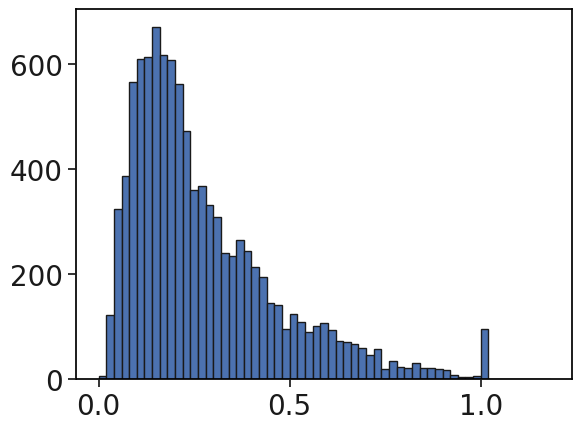

In [124]:
plt.hist(idx3,np.arange(0,1.2,0.02))

In [125]:
x = 0.05

idx3 = ((tmp.ct_df < 0.25).sum('pres')/tmp.ctemp.notnull().sum('pres')) > x
idx3 = np.where(idx3==0)[0]

Text(0.5, 0.98, '30 random temperature and density profiles')

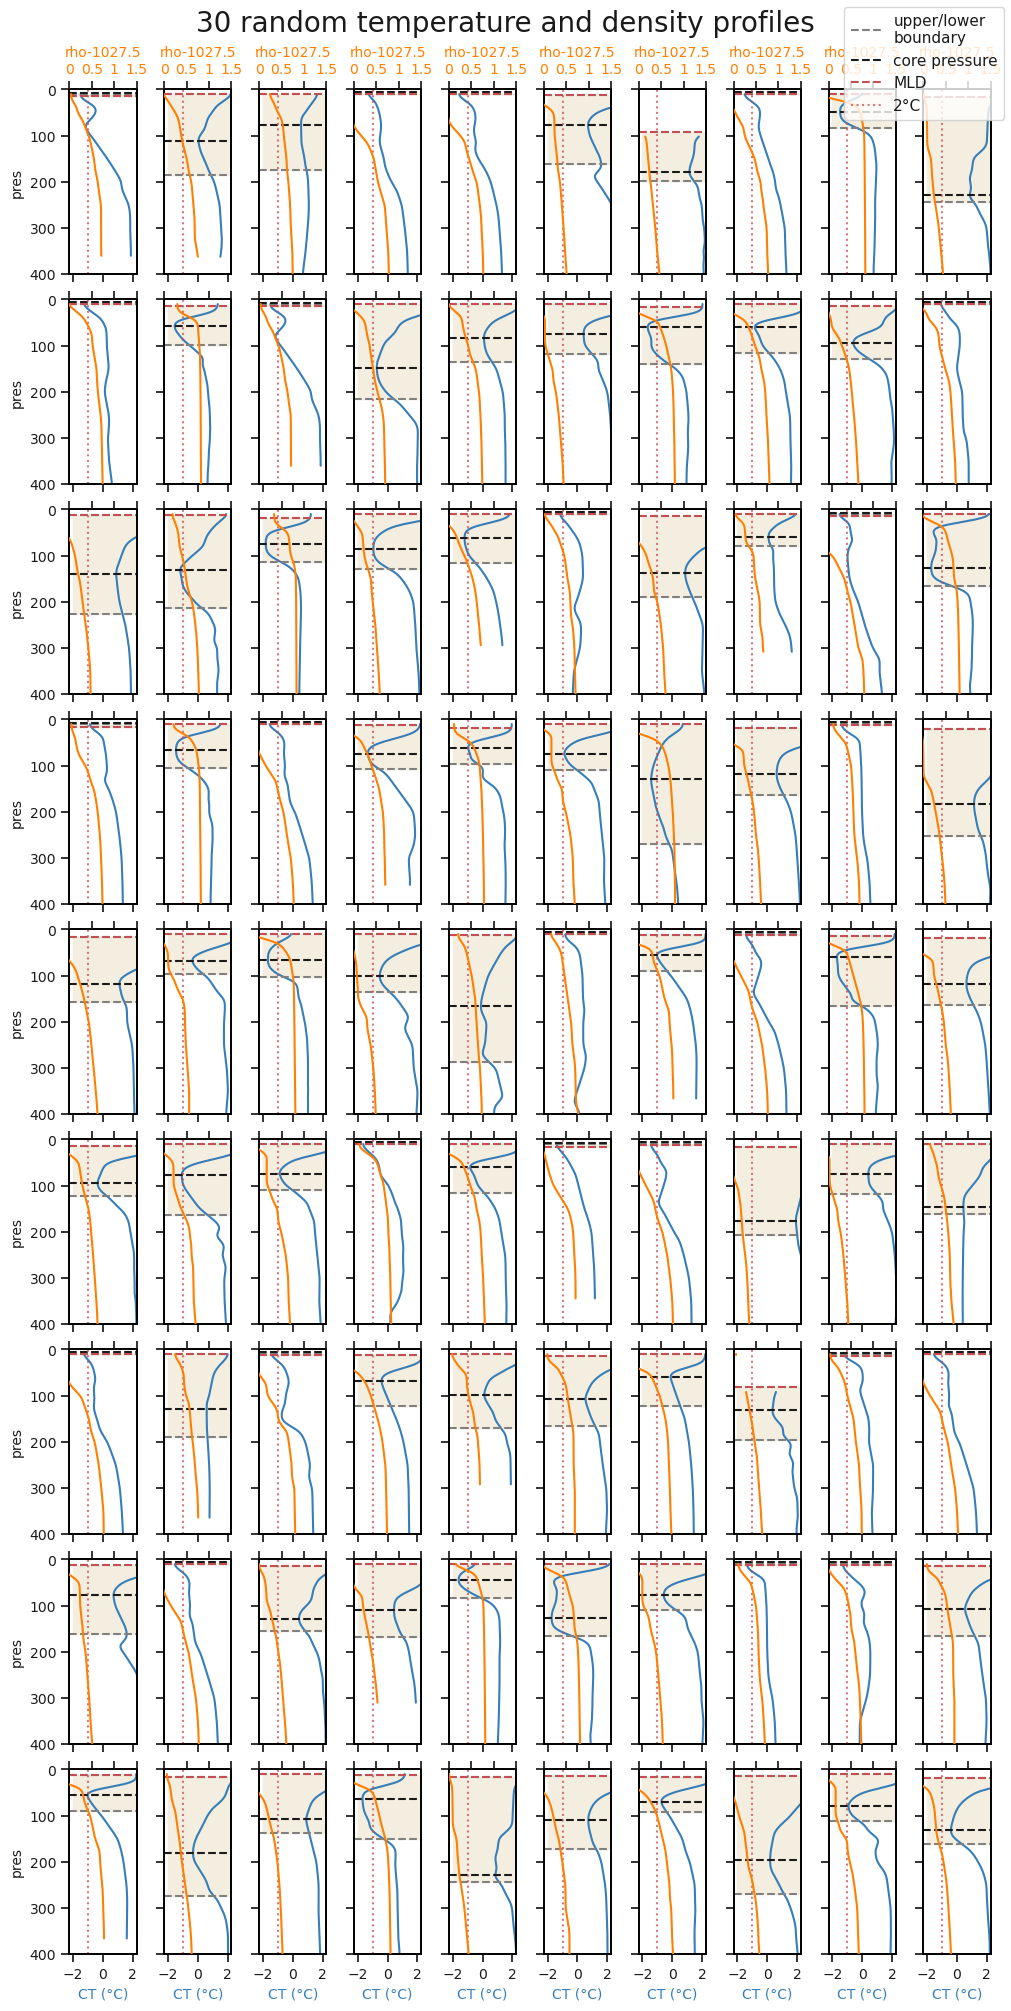

In [126]:
from random import randint

# set axes colours
c1 = '#377eb8'
c2 = '#ff7f00'

r = 9 # rows in figure
c = 10  # columns in figure

fig,ax = plt.subplots(r,c,figsize=[10,20],constrained_layout=True,sharex='col',sharey='row',#dpi=300
                     )
ax=ax.flatten()

for i in range(3):
    # choose 30 random profiles
    idx2 = []
    for j in range(30):
        idx2 += randint(0,idx3.size-1),
    chk = tmp.isel(n_prof=idx3[idx2])
    
    for k,a in enumerate(ax[i*30:(i+1)*30]):
        tmp2 = chk.isel(n_prof=k)

        tmp2.ctemp.plot(y='pres',ax=a,c=c1,lw=1.5)
        l1 = a.axes.axhline(tmp2.up_bd,ls='--',c='grey')
        l2 = a.axes.axhline(tmp2.lw_bd,ls='--',c='grey')
        l3 = a.axes.axhline(tmp2.ww_cp,ls='--',c='k')
        l4 = a.axes.axhline(tmp2.mlp,ls='--',c='r')
        l5 = a.axes.axvline(-1,ls=':',c='r',alpha=0.75)

        a.axes.invert_yaxis()
        a.set_xlabel('')
        a.set_ylabel('')
        a.set_xlim(-2.25,2.25)

        a.set_xticks([-2,0,2])
        ww = a.fill_between(x=np.arange(-2,6,0.1),y1=tmp2.up_bd,y2=tmp2.lw_bd,color='#f4eee0')

        a.set_ylim(400,0)
        a.set_title('')
        a.xaxis.label.set_color(c1)
        a.tick_params(axis='both',which='major',labelsize=10)
        
        
        # twin axis and plot density
        a1 = a.twiny()
        (tmp2.rho-1027).plot(y='pres',zorder=5,ax=a1,c=c2,)
        a1.set_xlim(0,1.5)
        a1.set_xticks(np.arange(0,2,0.5))
        a1.set_title('')
    
        a1.tick_params(axis='both',which='major',labelsize=10)
        a1.xaxis.label.set_color(c2)
        if i==0 and k in range(c):
            a1.set_xlabel('rho-1027.5',fontsize=10,)
            a1.set_xticklabels(['0','0.5','1','1.5'],c=c2,fontsize=10)
        else:
            a1.set_xlabel('')
            a1.set_xticklabels([])
    
for i,a in enumerate(ax[::c]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-c:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.legend([l1,l3,l4,l5],['upper/lower\nboundary','core pressure','MLD','2°C'])

fig.suptitle('30 random temperature and density profiles',fontsize=20)

Text(0.5, 0.98, 'type 1 temperature profiles for March')

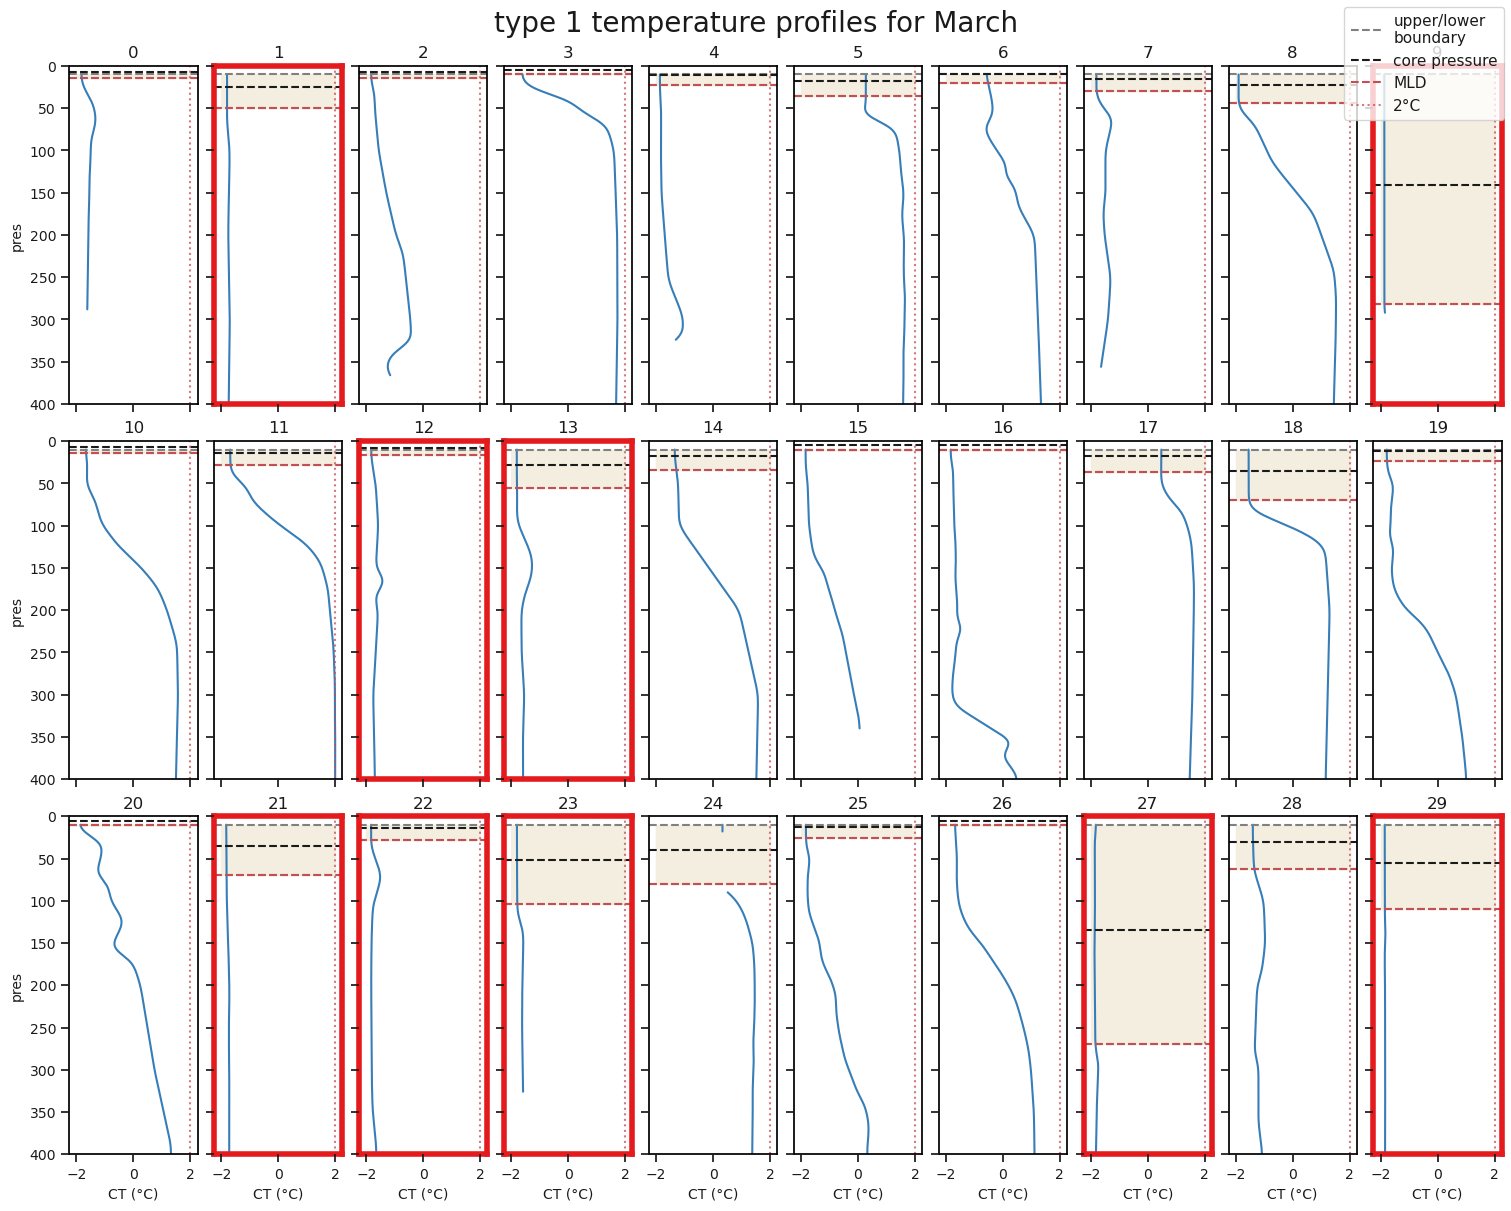

In [21]:
# index of profiles to drop based on verticality of temp profile

r = 3 # rows in figure
c = 10  # columns in figure

fig,ax = plt.subplots(r,c,figsize=[15,12],constrained_layout=True,sharex='col',sharey='row',#dpi=300
                     )
ax=ax.flatten()

i=0
for k,a in enumerate(ax[i*30:(i+1)*30]):
    tmp2 = chk.isel(n_prof=k)

    tmp2.ctemp.plot(y='pres',ax=a,c='#377eb8',lw=1.5)
    l1 = a.axes.axhline(tmp2.up_bd,ls='--',c='grey')
    l2 = a.axes.axhline(tmp2.lw_bd,ls='--',c='grey')
    l3 = a.axes.axhline(tmp2.ww_cp,ls='--',c='k')
    l4 = a.axes.axhline(tmp2.mlp,ls='--',c='r')
    l5 = a.axes.axvline(2,ls=':',c='r',alpha=0.75)

    a.axes.invert_yaxis()
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xlim(-2.25,2.25)

    a.set_xticks([-2,0,2])
    a.fill_between(x=np.arange(-2,2.1,0.1),y1=tmp2.up_bd,y2=tmp2.lw_bd,color='#f4eee0')

    a.set_ylim(400,0)
    a.set_title(chk.n_prof[k].data,fontsize=12)

    if k in np.where(idx == 1)[0]:
        plt.setp(a.spines.values(), color='#e41a1c',linewidth=4)
        plt.setp([a.get_xticklines(), a.get_yticklines()],color='#e41a1c',linewidth=5)
        
for i,a in enumerate(ax[::c]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-c:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.legend([l1,l3,l4,l5],['upper/lower\nboundary','core pressure','MLD','2°C'])

fig.suptitle('type 1 temperature profiles for March',fontsize=20)

# set red boundary around profiles to be dropped
#for ii,a in enumerate(ax[np.where(idx == 1)[0]]):
    #bbox = a.get_tightbbox(fig.canvas.get_renderer())
   # x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
    # slightly increase the very tight bounds:
  #  xpad = 0.05 * width
 #   ypad = 0.05 * height
#    fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor='red', linewidth=3, fill=False))

Text(0.5, 0.98, 'type 1 temperature profiles for March')

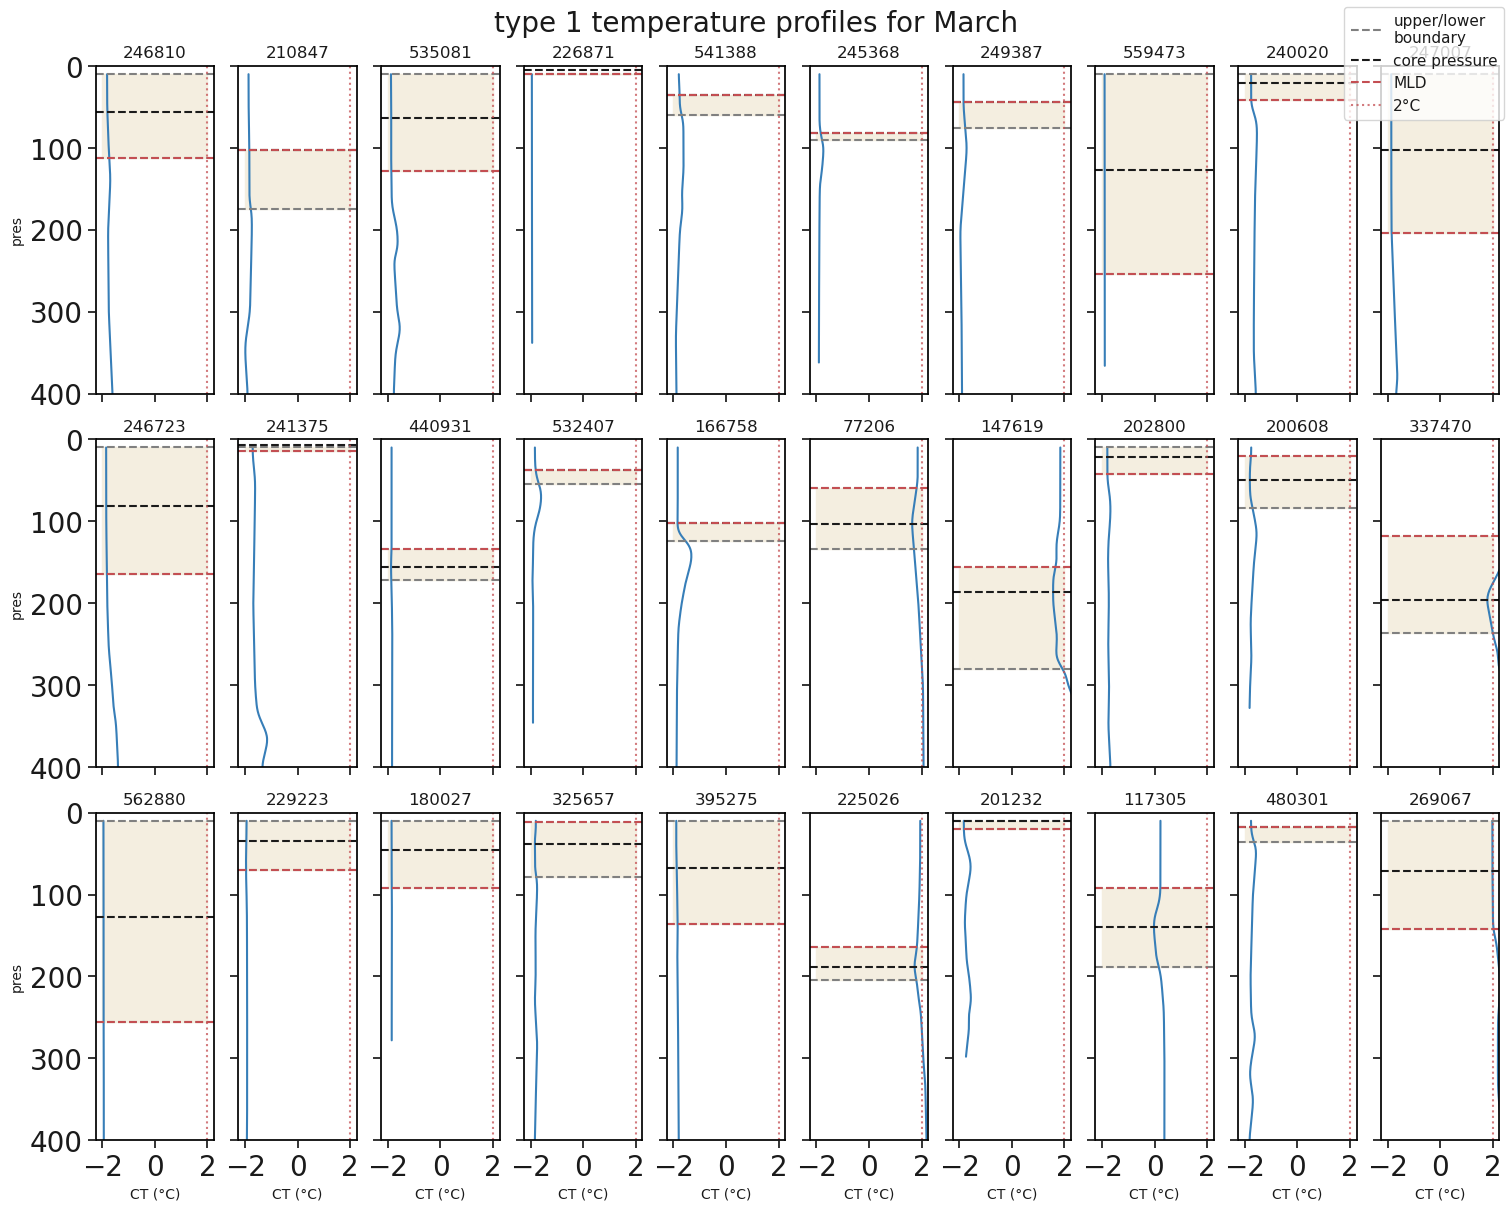

In [31]:
# index of profiles to drop based on verticality of temp profile

r = 3 # rows in figure
c = 10  # columns in figure

fig,ax = plt.subplots(r,c,figsize=[15,12],constrained_layout=True,sharex='col',sharey='row',#dpi=300
                     )
ax=ax.flatten()


for k,a in enumerate(ax):
    tmp2 = chk.isel(n_prof=k)

    tmp2.ctemp.plot(y='pres',ax=a,c='#377eb8',lw=1.5)
    l1 = a.axes.axhline(tmp2.up_bd,ls='--',c='grey')
    l2 = a.axes.axhline(tmp2.lw_bd,ls='--',c='grey')
    l3 = a.axes.axhline(tmp2.ww_cp,ls='--',c='k')
    l4 = a.axes.axhline(tmp2.mlp,ls='--',c='r')
    l5 = a.axes.axvline(2,ls=':',c='r',alpha=0.75)

    a.axes.invert_yaxis()
    a.set_xlabel('')
    a.set_ylabel('')
    a.set_xlim(-2.25,2.25)

    a.set_xticks([-2,0,2])
    a.fill_between(x=np.arange(-2,2.1,0.1),y1=tmp2.up_bd,y2=tmp2.lw_bd,color='#f4eee0')

    a.set_ylim(400,0)
    a.set_title(chk.n_prof[k].data,fontsize=12)

    if k in np.where(idx == 1)[0]:
        plt.setp(a.spines.values(), color='#e41a1c',linewidth=4)
        plt.setp([a.get_xticklines(), a.get_yticklines()],color='#e41a1c',linewidth=5)
        
for i,a in enumerate(ax[::c]):
    a.set_ylabel('pres',fontsize=10)
for i,a in enumerate(ax[-c:]):
    a.set_xlabel('CT (°C)',fontsize=10)
    
fig.legend([l1,l3,l4,l5],['upper/lower\nboundary','core pressure','MLD','2°C'])

fig.suptitle('type 1 temperature profiles for March',fontsize=20)

# set red boundary around profiles to be dropped
#for ii,a in enumerate(ax[np.where(idx == 1)[0]]):
    #bbox = a.get_tightbbox(fig.canvas.get_renderer())
   # x0, y0, width, height = bbox.transformed(fig.transFigure.inverted()).bounds
    # slightly increase the very tight bounds:
  #  xpad = 0.05 * width
 #   ypad = 0.05 * height
#    fig.add_artist(plt.Rectangle((x0-xpad, y0-ypad), width+2*xpad, height+2*ypad, edgecolor='red', linewidth=3, fill=False))

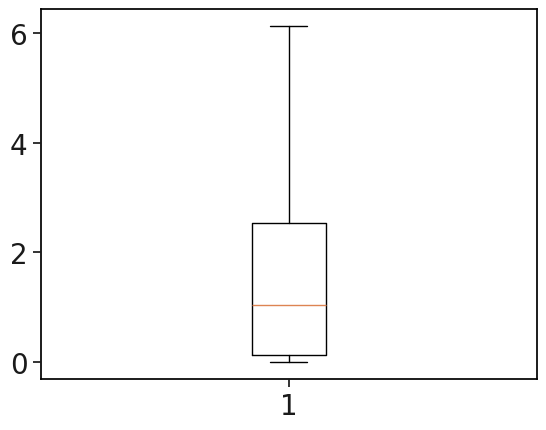

In [9]:
boxplot(tmp.ct_df)

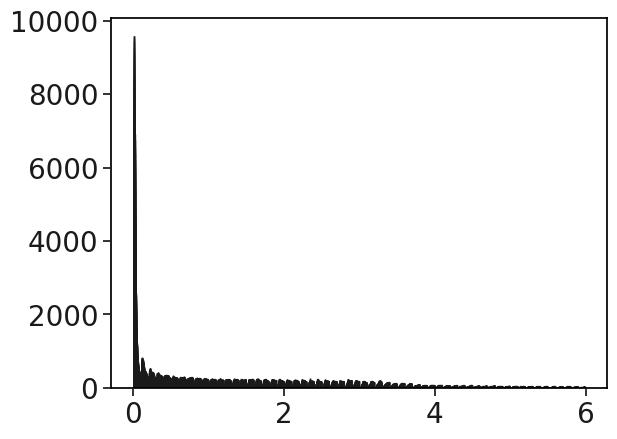

In [11]:
_=plt.hist(tmp.ct_df,np.arange(0,6.1,0.1))

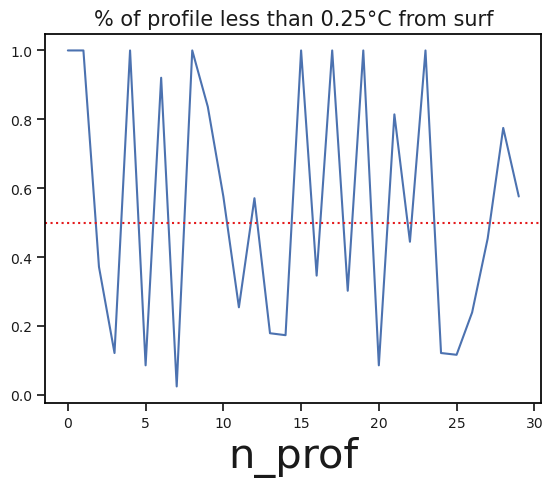

In [11]:
x = 0.5 # threshold value

# check number of data points with a change lower than 0.02 (uncertainty) as a %age of the total data points
((chk.ct_df < 0.25).sum('pres')/chk.ctemp.notnull().sum('pres')).plot()
plt.axhline(x,c='#e41a1c',ls=':')
plt.title('% of profile less than 0.25°C from surf',fontsize=15)
plt

idx = ((chk.ct_df < 0.25).sum('pres')/chk.ctemp.notnull().sum('pres')) > x